# Kaggle Competition : Child Mind Institute — Problematic Internet Use
### Relating Physical Activity to Problematic Internet Use
### Competition Link : <https://www.kaggle.com/competitions/child-mind-institute-problematic-
internet-use/overview>
### Compeition Dataset Link : <https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/data>


## train.csv and test.csv comprises measurements from a variety of instruments

- **Demographics** - Information about age and sex of participants.
- **Internet Use** - Number of hours of using computer/internet per day.
- **Children's Global Assessment Scale** - Numeric scale used by mental health clinicians to rate the general functioning of youths under the age of 18.
- **Physical Measures** - Collection of blood pressure, heart rate, height, weight and waist, and hip measurements.
- **FitnessGram Vitals and Treadmill** - Measurements of cardiovascular fitness assessed using the NHANES treadmill protocol.
- **FitnessGram Child** - Health related physical fitness assessment measuring five different parameters including aerobic capacity, muscular strength, muscular endurance, flexibility, and body composition.
- **Bio-electric Impedance Analysis** - Measure of key body composition elements, including BMI, fat, muscle, and water content.
- **Physical Activity Questionnaire** - Information about children's participation in vigorous activities over the last 7 days.
- **Sleep Disturbance Scale** - Scale to categorize sleep disorders in children.
- **Actigraphy** - Objective measure of ecological physical activity through a research-grade biotracker.
- **Parent-Child Internet Addiction Test** - 20-item scale that measures characteristics and behaviors associated with compulsive use of the Internet including compulsivity, escapism, and dependency.

- **Note** in particular the field **PCIAT-PCIAT_Total.** The target **sii** for this competition is derived from this field as described in the data dictionary: **0 for None, 1 for Mild, 2 for Moderate, and 3 for Severe.** Additionally, each participant has been assigned a unique identifier id.

### Actigraphy Files and Field Descriptions
During their participation in the HBN study, some participants were given an accelerometer to wear for up to 30 days continually while at home and going about their regular daily lives.

- **series_{train|test}.parquet/id={id}** - Series to be used as training data, partitioned by id. Each series is a continuous recording of accelerometer data for a single subject spanning many days.

- **id** - The patient identifier corresponding to the id field in train/test.csv.
- **step** - An integer timestep for each observation within a series.
- **X, Y, Z** - Measure of acceleration, in g, experienced by the wrist-worn watch along each standard axis.
- **enmo** - As calculated and described by the wristpy package, ENMO is the Euclidean Norm Minus One of all accelerometer signals (along each of the x-, y-, and z-axis, measured in g-force) with negative values rounded to zero. Zero values are indicative of periods of no motion. While no standard measure of acceleration exists in this space, this is one of the several commonly computed features.
- **anglez** - As calculated and described by the wristpy package, Angle-Z is a metric derived from individual accelerometer components and refers to the angle of the arm relative to the horizontal plane.
- **non-wear_flag** - A flag (0: watch is being worn, 1: the watch is not worn) to help determine periods when the watch has been removed, based on the GGIR definition, which uses the standard deviation and range of the accelerometer data.
- **light** - Measure of ambient light in lux. See ​​here for details.
- **battery_voltage** - A measure of the battery voltage in mV.
- **time_of_day** - Time of day representing the start of a 5s window that the data has been sampled over, with format **%H:%M:%S.%9f.**
- **weekday** - The day of the week, coded as an integer with 1 being Monday and 7 being Sunday.
- **quarter** - The quarter of the year, an integer from 1 to 4.
- **relative_date_PCIAT** - The number of days (integer) since the PCIAT test was administered (negative days indicate that the actigraphy data has been collected before the test was administered).

# Install library

In [1]:
installpath = "/kaggle/input/tabnet/pytorch/v1/1/pytorch_tabnet-4.1.0-py3-none-any.whl"
!pip install pytorch-tabnet --no-index --no-deps --find-links=file://{installpath}

Looking in links: file:///kaggle/input/tabnet/pytorch/v1/1/pytorch_tabnet-4.1.0-py3-none-any.whl
Processing /kaggle/input/tabnet/pytorch/v1/1/pytorch_tabnet-4.1.0-py3-none-any.whl


# Config

In [2]:
class CFG:
    
    USE_GPU= False
    test =0.2
    normalize = False#True
    overSampling = True # handling imbalance class
    crossValidate = True#True # Support cross Validation 
    nFold = 5#4 # 8  No remainder  for oversampling 


    USE_XGB = True
    USE_TABNET = True

    # XGBoost
    xgbEstimate = 200 # 250 , 300 
    xgbDepth = 7 #5 #6, low value avoid overfit
    xgbLR = 0.05 # 0.08

    # Tabnet model hyperparameter 
    maxEpochs = 1000
    n_d =32 #8
    n_a = 32 # 8
    n_steps = 5 # 3
    mask_type = "entmax" # "sparsemax"
    learningRate = 1e-3 # 1e-2
    
    trainSeriesParquet = "series_train.parquet"
    testSeriesParquet = "series_test.parquet"
    rootDir ="/kaggle/input/child-mind-institute-problematic-internet-use/"
    dataDictionary = "/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv"
    trainDataFile= "/kaggle/input/child-mind-institute-problematic-internet-use/train.csv"
    testDataFile = "/kaggle/input/child-mind-institute-problematic-internet-use/test.csv"
    samplesub = "/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv"
    

In [3]:

import os, gc, time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from IPython.display import Markdown
import ctypes
import seaborn as sns
from tqdm import tqdm

import torch
from pytorch_tabnet.tab_model import TabNetClassifier


from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (train_test_split, KFold, GridSearchCV, StratifiedKFold,
                                    cross_val_score)
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# over Sample 
from imblearn.over_sampling import SMOTE

from sklearn.metrics import ( mean_absolute_error, 
                             mean_squared_error, 
                             r2_score, 
                             cohen_kappa_score)

from sklearn.model_selection import (train_test_split, 
                                     KFold, 
                                     GridSearchCV, 
                                     StratifiedKFold)


# import torch
# ML library 
from xgboost import XGBRFRegressor, XGBClassifier# plot_importance, plot_tree
import xgboost
from lightgbm import LGBMRegressor, LGBMClassifier
import lightgbm
from catboost import CatBoostRegressor, CatBoostClassifier
import catboost
from sklearn.ensemble import (RandomForestRegressor,  RandomForestClassifier ,
                              VotingRegressor, VotingClassifier )

# multiple processing lib
from joblib import Parallel , delayed
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Load dataset

### Load meta Data 
#### help us to understand the data feature

In [5]:
%%time
dataDictDF = pd.read_csv(CFG.dataDictionary)
dataDictDF

CPU times: user 5.46 ms, sys: 1.12 ms, total: 6.59 ms
Wall time: 11.8 ms


,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
5,Children's Global Assessment Scale,CGAS-CGAS_Score,Children's Global Assessment Scale Score,int,NaN,NaN
6,Physical Measures,Physical-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
7,Physical Measures,Physical-BMI,Body Mass Index (kg/m^2),float,NaN,NaN
8,Physical Measures,Physical-Height,Height (in),float,NaN,NaN
9,Physical Measures,Physical-Weight,Weight (lbs),float,NaN,NaN


In [6]:
pd.set_option('display.max_rows', 50)

In [7]:
%%time
trainDataDF = pd.read_csv(CFG.trainDataFile)
trainDataDF


CPU times: user 31.2 ms, sys: 16.2 ms, total: 47.4 ms
Wall time: 61.3 ms


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,ff8a2de4,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,NaN,71.0,70.0,104.0,NaN,NaN,NaN,NaN,Fall,16.0,0.0,18.0,1.0,19.9,2.0,10.0,1.0,8.0,1.0,9.0,1.0,12.0,1.0,Fall,3.0,4.52277,16.3642,1206.880,2051.70,19.46110,70.8117,14.0629,2.30138,11.58830,1.0,33.3709,17.97970,66.2889,29.7790,52.8320,NaN,NaN,Winter,3.260,Winter,3.0,3.0,3.0,2.0,3.0,2.0,2.0,2.0,2.0,1.0,2.0,0.0,2.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,32.

In [8]:
trainDataDF.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
count,3960.000000,3960.000000,2421.000000,3022.000000,3027.000000,3076.000000,898.000000,2954.000000,2967.000000,2954.000000,743.000000,740.000000,740.000000,2322.000000,2282.000000,1074.000000,1062.000000,1074.000000,1063.000000,2310.000000,2271.000000,2305.000000,2267.000000,2307.000000,2269.000000,2324.000000,2285.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.00000,1991.000000,1991.000000,1991.000000,475.000000,1721.000000,2733.000000,2734.000000,2731.000000,2731.000000,2729.000000,2732.000000,2729.000000,2730.000000,2730.000000,2733.000000,2734.000000,2731.000000,2729.000000,2732.000000,2730.000000,2728.000000,2725.000000,2728.000000,2730.000000,2733.000000,2736.000000,2609.000000,2606.000000,3301.000000,2736.000000
mean,10.433586,0.372727,65.454771,19.331929,55.946713,89.038615,27.278508,69.648951,81.597236,116.983074,4.989233,7.370270,27.581081,11.259690,0.476337,22.420438,1.829567,23.518622,1.904045,5.579654,0.330251,8.694924,0.618880,8.805635,0.620097,9.252775,0.785558,2.651431,6.719826,19.367048,1237.018187,2064.693747,20.825346,74.021708,15.030554,4.336495,16.855020,1.745354,33.173380,20.02299,67.301883,34.389466,53.998726,2.178853,2.589550,2.370655,2.177762,2.399854,0.839253,2.297545,1.063690,0.586295,1.246520,1.062637,1.304793,1.685443,0.244599,1.340051,1.035505,1.499634,1.452346,1.627890,1.613636,1.158974,0.943652,27.896199,41.088923,57.763622,1.060588,0.580409
std,3.574648,0.483591,22.341862,5.113934,7.473764,44.569040,5.567287,13.611226,13.665196,17.061225,2.014072,3.189662,17.707751,11.807781,0.499549,10.833995,0.612585,11.148951,0.612344,7.390161,0.470407,3.429301,0.485769,3.422167,0.485469,2.988863,0.410525,1.028267,92.586325,5.047848,1872.383246,2836.246272,73.266287,199.433753,5.792505,6.356402,199.372119,0.680635,56.272346,70.21561,108.705918,84.050607,129.362539,0.849476,0.783937,1.673312,1.697117,1.588807,1.195601,1.705218,1.268282,1.049355,1.342582,1.258797,1.331715,1.543074,0.522956,1.411156,1.301712,1.492929,1.495600,1.445622,1.529178,1.343661,1.185460,20.338853,10.427433,13.196091,1.094875,0.771122
min,5.000000,0.000000,25.000000,0.000000,33.000000,0.000000,18.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-7.789610,0.048267,813.397000,1073.450000,1.789450,28.900400,7.864850,-194.163000,-8745.080000,1.000000,14.489000,4.63581,23.620100,4.655730,20.589200,0.660000,0.580000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,38.000000,0.000000,0.000000
25%,8.000000,0.000000,59.000000,15.869350,50.000000,57.200000

In [9]:
%%time
testDataDF = pd.read_csv(CFG.testDataFile)
testDataDF

CPU times: user 4.96 ms, sys: 4 µs, total: 4.97 ms
Wall time: 7.12 ms


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.00,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.00,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.50,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.00,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.50,112.2,NaN,60.0,73.0,102.0,NaN,NaN,NaN,NaN,Summer,12.0,0.0,16.5,2.0,17.9,2.0,6.0,0.0,10.0,1.0,11.0,1.0,8.0,0.0,Summer,2.0,4.33036,30.1865,1330.970,1996.45,30.21240,84.0285,16.6877,13.49880,67.97150,2.0,32.9141,20.90200,79.6982,35.3804,63.1265,NaN,NaN,Spring,4.110,Summer,40.0,56.0,Spring,0.0
6,0038ba98,Fall,10,0,NaN,NaN,Fall,19.660760,55.00,84.6,NaN,123.0,83.0,163.0,NaN,NaN,NaN,NaN,Fall,9.0,1.0,NaN,NaN,NaN,NaN,2.0,0.0,11.0,1.0,11.0,1.0,11.0,1.0,Fall,2.0,3.78271,19.6629,1135.860,1817.38,16.32750,63.2470,14.7000,4.96291,21.35300,2.0,30.8936,16.02590,59.4643,26.1957,47.2211,NaN,NaN,Winter,3.670,Winter,27.0,40.0,Fall,3.0
7,0068a485,Fall,10,1,NaN,NaN,Fall,16.861286,59.25,84.2,27.0,71.0,90.0,116.0,NaN,NaN,NaN,NaN,Fall,0.0,0.0,12.6,2.0,11.1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,Fall,3.0,4.05726,16.8631,1180.040,1888.06,21.94000,67.9527,13.6092,3.25395,16.24740,2.0,28.5367,17.47600,63.8954,28.7680,50.4767,NaN,NaN,Fall,1.270,NaN,NaN,NaN,Fall,2.0
8,0069fbed,Summer,15,0,NaN,NaN,Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.0
9,0083e397,Summer,19,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
testDataDF.shape

(20, 59)

In [11]:
submit = pd.read_csv(CFG.samplesub)
submit

,id,sii
0,00008ff9,0
1,000fd460,1
2,00105258,2
3,00115b9f,3
4,0016bb22,0
5,001f3379,1
6,0038ba98,2
7,0068a485,3
8,0069fbed,0
9,0083e397,1


In [12]:
def cleanMemory():
    gc.collect()
    ctypes.CDLL("libc.so.6").malloc_trim(0)
    torch.cuda.empty_cache()

In [13]:
cleanMemory()

## Print Columns Values 

In [14]:
def printAllcolumnsValue(df, showAll=True):
    for col in df.columns:
        if showAll :
            print(f"{col} : {df[col].unique()}") # print unique value
        else: # only print catergory column
            if df[col].dtype == "object":
                print(f"{col} : {df[col].unique()}") # print unique value

In [15]:
def printSerieUniqueValue(df):
    print(f" {df.unique()}")

In [16]:
printSerieUniqueValue(trainDataDF["Basic_Demos-Age"])

 [ 5  9 10 18 13 15 19 11 12  7  6 14 16  8 21 17 20 22]


In [17]:
printSerieUniqueValue(trainDataDF["Physical-Waist_Circumference"])

 [  nan 22.   27.   24.   30.   35.   25.   26.   28.   31.   33.   23.
 21.   29.   37.   36.   34.   31.5  21.5  38.   32.   49.   25.5  19.
 20.   40.   50.   39.   22.5  42.   43.   48.   27.1  18.   27.75 46.
 23.5  45.   44.   41.   45.5  23.75 41.5  28.5  30.5 ]


In [18]:
printSerieUniqueValue(trainDataDF["Physical-Height"])

 [46.   48.   56.5  56.     nan 59.5  55.   59.25 57.75 60.   54.   44.
 37.5  66.5  71.   60.5  69.   62.   53.2  47.   60.2  49.   50.5  50.
 52.   48.5  53.5  59.   60.24 64.25 45.5  64.   53.   74.   64.75 67.5
 68.   58.25 55.25 51.5  60.25 54.25 50.75 46.5  49.5  63.   63.5  51.
 54.6  77.   61.5  52.5  56.25 66.   53.57 58.5  59.6  48.2  46.6  57.
 51.25 62.6  55.5  42.5  44.5  45.   50.25 51.2  63.75 54.5  70.5  61.
 57.5  70.   49.25 69.5  67.   48.75 41.   47.2  64.5  66.1  68.5  66.8
 70.15 67.25 43.   71.5  58.2  62.75 46.75 40.5  56.75 65.5  58.   42.
 60.05 51.75 54.75 61.75 43.5  47.5  59.88 51.63 65.   62.5  60.75 47.02
 54.65 60.4  46.8  75.75 68.75 55.88 67.13 46.1  69.1  64.3  48.25 57.88
 42.75 52.88 60.8  66.6  60.84 49.75 64.13 65.25 44.25 60.63 72.64 53.1
 73.   78.5  52.2  62.9  53.3  62.7  69.6  39.   72.   51.38 49.2  62.8
 44.75 52.75 58.75 66.75 53.9  55.75 51.6  55.2  57.13 55.3  56.3  50.2
 57.25 47.4  75.2  50.63 45.75 62.2  47.8  65.75 71.2  65.4  53.88 

In [19]:
printSerieUniqueValue(trainDataDF["BIA-BIA_Fat"])

 [ 9.21377  3.97085      nan ... 11.5883  33.9967  -5.90917]


### Get Feature 

In [20]:
for item in trainDataDF.columns:
    print(item)

id
Basic_Demos-Enroll_Season
Basic_Demos-Age
Basic_Demos-Sex
CGAS-Season
CGAS-CGAS_Score
Physical-Season
Physical-BMI
Physical-Height
Physical-Weight
Physical-Waist_Circumference
Physical-Diastolic_BP
Physical-HeartRate
Physical-Systolic_BP
Fitness_Endurance-Season
Fitness_Endurance-Max_Stage
Fitness_Endurance-Time_Mins
Fitness_Endurance-Time_Sec
FGC-Season
FGC-FGC_CU
FGC-FGC_CU_Zone
FGC-FGC_GSND
FGC-FGC_GSND_Zone
FGC-FGC_GSD
FGC-FGC_GSD_Zone
FGC-FGC_PU
FGC-FGC_PU_Zone
FGC-FGC_SRL
FGC-FGC_SRL_Zone
FGC-FGC_SRR
FGC-FGC_SRR_Zone
FGC-FGC_TL
FGC-FGC_TL_Zone
BIA-Season
BIA-BIA_Activity_Level_num
BIA-BIA_BMC
BIA-BIA_BMI
BIA-BIA_BMR
BIA-BIA_DEE
BIA-BIA_ECW
BIA-BIA_FFM
BIA-BIA_FFMI
BIA-BIA_FMI
BIA-BIA_Fat
BIA-BIA_Frame_num
BIA-BIA_ICW
BIA-BIA_LDM
BIA-BIA_LST
BIA-BIA_SMM
BIA-BIA_TBW
PAQ_A-Season
PAQ_A-PAQ_A_Total
PAQ_C-Season
PAQ_C-PAQ_C_Total
PCIAT-Season
PCIAT-PCIAT_01
PCIAT-PCIAT_02
PCIAT-PCIAT_03
PCIAT-PCIAT_04
PCIAT-PCIAT_05
PCIAT-PCIAT_06
PCIAT-PCIAT_07
PCIAT-PCIAT_08
PCIAT-PCIAT_09
PCIAT-

In [21]:
noColumnInTest = [ item for item in trainDataDF.columns  if item not in testDataDF.columns]
noColumnInTest

['PCIAT-Season',
 'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_02',
 'PCIAT-PCIAT_03',
 'PCIAT-PCIAT_04',
 'PCIAT-PCIAT_05',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_08',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_10',
 'PCIAT-PCIAT_11',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_14',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_16',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_20',
 'PCIAT-PCIAT_Total',
 'sii']

In [22]:
featureCols = trainDataDF.columns.tolist()
featureCols.remove("id")
featureCols , len(featureCols)

(['Basic_Demos-Enroll_Season',
  'Basic_Demos-Age',
  'Basic_Demos-Sex',
  'CGAS-Season',
  'CGAS-CGAS_Score',
  'Physical-Season',
  'Physical-BMI',
  'Physical-Height',
  'Physical-Weight',
  'Physical-Waist_Circumference',
  'Physical-Diastolic_BP',
  'Physical-HeartRate',
  'Physical-Systolic_BP',
  'Fitness_Endurance-Season',
  'Fitness_Endurance-Max_Stage',
  'Fitness_Endurance-Time_Mins',
  'Fitness_Endurance-Time_Sec',
  'FGC-Season',
  'FGC-FGC_CU',
  'FGC-FGC_CU_Zone',
  'FGC-FGC_GSND',
  'FGC-FGC_GSND_Zone',
  'FGC-FGC_GSD',
  'FGC-FGC_GSD_Zone',
  'FGC-FGC_PU',
  'FGC-FGC_PU_Zone',
  'FGC-FGC_SRL',
  'FGC-FGC_SRL_Zone',
  'FGC-FGC_SRR',
  'FGC-FGC_SRR_Zone',
  'FGC-FGC_TL',
  'FGC-FGC_TL_Zone',
  'BIA-Season',
  'BIA-BIA_Activity_Level_num',
  'BIA-BIA_BMC',
  'BIA-BIA_BMI',
  'BIA-BIA_BMR',
  'BIA-BIA_DEE',
  'BIA-BIA_ECW',
  'BIA-BIA_FFM',
  'BIA-BIA_FFMI',
  'BIA-BIA_FMI',
  'BIA-BIA_Fat',
  'BIA-BIA_Frame_num',
  'BIA-BIA_ICW',
  'BIA-BIA_LDM',
  'BIA-BIA_LST',
  'BIA-B

## load Time serise data

In [23]:
# read one of time series data
trainSerise1 = pd.read_parquet("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=00115b9f/part-0.parquet")
trainSerise1

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
0,0,0.021536,0.022214,-1.022370,0.022853,-88.280762,0.0,53.000000,4188.000000,56940000000000,4,3,41.0
1,1,0.022005,0.022187,-1.019740,0.020231,-88.241707,0.0,51.666668,4188.166504,56945000000000,4,3,41.0
2,2,0.022240,0.022005,-1.019401,0.019893,-88.170067,0.0,50.333332,4188.333496,56950000000000,4,3,41.0
3,3,0.021589,0.022578,-1.018177,0.018667,-88.250031,0.0,50.500000,4188.500000,56955000000000,4,3,41.0
4,4,0.022005,0.023763,-1.014323,0.016848,-88.130775,0.0,33.166668,4181.000000,57235000000000,4,3,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43325,43325,-0.008333,-0.023620,-1.006901,0.007224,-88.595741,0.0,0.000000,3824.000000,57580000000000,6,3,85.0
43326,43326,0.048730,-0.076725,-0.953776,0.056839,-85.352219,0.0,0.000000,3824.000000,57640000000000,6,3,85.0
43327,43327,0.387370,0.793151,-0.402214,0.069961,-24.097908,0.0,0.000000,3824.000000,57645000000000,6,3,85.0
43328,43328,0.801953,0.501589,-0.040937,0.045489,-2.113776,0.0,0.000000,3824.000000,57650000000000,6,3,85.0


In [24]:
trainSerise1.drop("step", axis=1, inplace=True)
trainSerise1

,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
0,0.021536,0.022214,-1.022370,0.022853,-88.280762,0.0,53.000000,4188.000000,56940000000000,4,3,41.0
1,0.022005,0.022187,-1.019740,0.020231,-88.241707,0.0,51.666668,4188.166504,56945000000000,4,3,41.0
2,0.022240,0.022005,-1.019401,0.019893,-88.170067,0.0,50.333332,4188.333496,56950000000000,4,3,41.0
3,0.021589,0.022578,-1.018177,0.018667,-88.250031,0.0,50.500000,4188.500000,56955000000000,4,3,41.0
4,0.022005,0.023763,-1.014323,0.016848,-88.130775,0.0,33.166668,4181.000000,57235000000000,4,3,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...
43325,-0.008333,-0.023620,-1.006901,0.007224,-88.595741,0.0,0.000000,3824.000000,57580000000000,6,3,85.0
43326,0.048730,-0.076725,-0.953776,0.056839,-85.352219,0.0,0.000000,3824.000000,57640000000000,6,3,85.0
43327,0.387370,0.793151,-0.402214,0.069961,-24.097908,0.0,0.000000,3824.000000,57645000000000,6,3,85.0
43328,0.801953,0.501589,-0.040937,0.045489,-2.113776,0.0,0.000000,3824.000000,57650000000000,6,3,85.0


In [25]:
sensorFeature =trainSerise1.columns.to_list()
sensorFeature , len(sensorFeature)


(['X',
  'Y',
  'Z',
  'enmo',
  'anglez',
  'non-wear_flag',
  'light',
  'battery_voltage',
  'time_of_day',
  'weekday',
  'quarter',
  'relative_date_PCIAT'],
 12)

In [26]:
# get Statistic Feature list
statFeat = trainSerise1.describe().index.to_list() 
statFeat, len(statFeat)

(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 8)

# generate senor feature statistic column list

In [27]:
# generate senor feature statistic column list
sensorStatCol = []
for sta in statFeat: # start statist row 
    # print(sta)
    for item in sensorFeature:
        # print(item)
        sensorStatCol.append(f"{item}_{sta}")
        
sensorStatCol, len(sensorStatCol)

(['X_count',
  'Y_count',
  'Z_count',
  'enmo_count',
  'anglez_count',
  'non-wear_flag_count',
  'light_count',
  'battery_voltage_count',
  'time_of_day_count',
  'weekday_count',
  'quarter_count',
  'relative_date_PCIAT_count',
  'X_mean',
  'Y_mean',
  'Z_mean',
  'enmo_mean',
  'anglez_mean',
  'non-wear_flag_mean',
  'light_mean',
  'battery_voltage_mean',
  'time_of_day_mean',
  'weekday_mean',
  'quarter_mean',
  'relative_date_PCIAT_mean',
  'X_std',
  'Y_std',
  'Z_std',
  'enmo_std',
  'anglez_std',
  'non-wear_flag_std',
  'light_std',
  'battery_voltage_std',
  'time_of_day_std',
  'weekday_std',
  'quarter_std',
  'relative_date_PCIAT_std',
  'X_min',
  'Y_min',
  'Z_min',
  'enmo_min',
  'anglez_min',
  'non-wear_flag_min',
  'light_min',
  'battery_voltage_min',
  'time_of_day_min',
  'weekday_min',
  'quarter_min',
  'relative_date_PCIAT_min',
  'X_25%',
  'Y_25%',
  'Z_25%',
  'enmo_25%',
  'anglez_25%',
  'non-wear_flag_25%',
  'light_25%',
  'battery_voltage_25%'

In [28]:
# Result 12(paramter) x 8 (statistic) = 96 (Data vector) summary (statistic for each type of sensor feature)
trainSerise1.describe().values.reshape(-1)

array([ 4.33300000e+04,  4.33300000e+04,  4.33300000e+04,  4.33300000e+04,
        4.33300000e+04,  4.33300000e+04,  4.33300000e+04,  4.33300000e+04,
        4.33300000e+04,  4.33300000e+04,  4.33300000e+04,  4.33300000e+04,
       -3.16383511e-01,  1.60087924e-02, -1.67890102e-01,  4.73876111e-02,
       -1.05804157e+01,  0.00000000e+00,  4.22963104e+01,  4.05357910e+03,
        5.04621484e+13,  4.47018232e+00,  3.00000000e+00,  5.32016830e+01,
        4.53664839e-01,  5.02702117e-01,  5.85709691e-01,  1.06351145e-01,
        4.29471703e+01,  0.00000000e+00,  2.08168976e+02,  1.12404045e+02,
        1.94284235e+13,  1.93142120e+00,  0.00000000e+00,  1.42449141e+01,
       -1.74609375e+00, -2.90533853e+00, -1.04837239e+00,  0.00000000e+00,
       -8.98330917e+01,  0.00000000e+00,  0.00000000e+00,  3.82400000e+03,
        5.50000000e+10,  1.00000000e+00,  3.00000000e+00,  4.10000000e+01,
       -6.84179693e-01, -3.09863284e-01, -6.49973929e-01,  6.43158494e-03,
       -4.15418634e+01,  

In [29]:
def loadParquetFile(directory, fileName):
    """
    read parquet file 
    """
    path = os.path.join(directory, fileName, "part-0.parquet")
    df = pd.read_parquet(path)
    df.drop("step", axis=1, inplace=True) # drop step column
    statDF = df.describe().values.reshape(-1)
    return statDF, fileName.split("=")[1] # get ids
    

def loadTimeSeriesData(directory):
    """
    input : root direction
    """
#     print("DIR :", directory)
    filesIds = os.listdir(directory) # get list of folder name (files ids)
#     print(filesIds)
    with ThreadPoolExecutor() as executor:
#     with ProcessPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: loadParquetFile(directory, fname), filesIds), total=len(filesIds)))
#     print(results)
    statistic, ids = zip(*results) # pack into Statistic and Ids 
    # create new dataframe with n statistic sensor data
#     data = pd.DataFrame(statistic, columns=[f"stat_{i}" for i in range(len(statistic[0]))])
    data = pd.DataFrame(statistic, columns=sensorStatCol)
    data["id"] = ids # add ids into dataframe
#     print(data)
    
    return data

In [30]:
%%time
trainTSData = loadTimeSeriesData((CFG.rootDir + CFG.trainSeriesParquet))
testTSData = loadTimeSeriesData((CFG.rootDir + CFG.testSeriesParquet))

100%|██████████| 2/2 [00:00<00:00,  9.40it/s]

CPU times: user 3min 47s, sys: 29.6 s, total: 4min 16s
Wall time: 1min 24s


In [31]:
trainTSData.head()

,X_count,Y_count,Z_count,enmo_count,anglez_count,non-wear_flag_count,light_count,battery_voltage_count,time_of_day_count,weekday_count,quarter_count,relative_date_PCIAT_count,X_mean,Y_mean,Z_mean,enmo_mean,anglez_mean,non-wear_flag_mean,light_mean,battery_voltage_mean,time_of_day_mean,weekday_mean,quarter_mean,relative_date_PCIAT_mean,X_std,Y_std,Z_std,enmo_std,anglez_std,non-wear_flag_std,light_std,battery_voltage_std,time_of_day_std,weekday_std,quarter_std,relative_date_PCIAT_std,X_min,Y_min,Z_min,enmo_min,anglez_min,non-wear_flag_min,light_min,battery_voltage_min,time_of_day_min,weekday_min,quarter_min,relative_date_PCIAT_min,X_25%,Y_25%,Z_25%,enmo_25%,anglez_25%,non-wear_flag_25%,light_25%,battery_voltage_25%,time_of_day_25%,weekday_25%,quarter_25%,relative_date_PCIAT_25%,X_50%,Y_50%,Z_50%,enmo_50%,anglez_50%,non-wear_flag_50%,light_50%,battery_voltage_50%,time_of_day_50%,weekday_50%,quarter_50%,relative_date_PCIAT_50%,X_75%,Y_75%,Z_75%,enmo_75%,anglez_75%,non-wear_flag_75%,light_75%,battery_voltage_75%,time_of_day_75%,weekday_75%,quarter_75%,relative_date_PCIAT_75%,X_max,Y_max,Z_max,enmo_max,anglez_max,non-wear_flag_max,light_max,battery_voltage_max,time_of_day_max,weekday_max,quarter_max,relative_date_PCIAT_max,id
0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,-0.054638,-0.163923,-0.114302,0.045252,-7.805897,0.000000,46.009533,4027.514893,5.415475e+13,4.438860,2.000000,30.202068,0.633126,0.513286,0.500372,0.132576,34.917873,0.000000,205.862213,108.451317,1.876976e+13,1.825557,0.000000,11.773107,-1.812031,-2.631380,-1.798073,0.0,-89.987045,0.0,0.0,3829.000000,0.000000e+00,1.0,2.0,15.0,-0.701660,-0.619076,-0.536432,0.007953,-32.948602,0.0,2.520257,3958.000000,4.325125e+13,3.0,2.0,17.0,0.015846,-0.141810,-0.104193,0.019257,-6.358004,0.0,8.230733,4029.0,5.630500e+13,5.0,2.0,28.0,0.437897,0.148919,0.223770,0.036048,13.095750,0.0,24.750000,4146.0,6.978000e+13,6.0,2.0,38.0,1.850391,3.580182,1.738203,5.314874,89.422226,0.0,2626.199951,4187.0,8.639500e+13,7.0,2.0,57.0,0745c390
1,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,0.113277,0.093139,-0.106038,0.028960,-6.065619,0.046508,56.437958,3829.466064,4.331149e+13,3.840885,2.000000,232.909103,0.507897,0.541129,0.603787,0.096825,44.034721,0.208482,206.625092,167.600983,2.509136e+13,1.957999,0.000000,5.701968,-1.807955,-2.887664,-1.004992,0.0,-89.654587,0.0,0.0,3098.166748,0.000000e+00,1.0,2.0,223.0,-0.231743,-0.257600,-0.595426,0.000367,-37.326844,0.0,4.000000,3724.000000,2.128500e+13,2.0,2.0,228.0,0.094074,0.068143,-0.228500,0.005257,-13.454103,0.0,10.050480,3812.0,4.360500e+13,4.0,2.0,233.0,0.517859,0.542323,0.312333,0.020598,18.462269,0.0,27.490936,3958.0,6.511000e+13,5.0,2.0,238.0,1.928769,3.234613,2.475326,3.966906,89.080330,1.0,2628.199951,4146.0,8.639500e+13,7.0,2.0,243.0,eaab7a96
2,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,-0.499738,0.046381,-0.181152,0.056544,-11.934993,0.000000,77.305130,4106.425781,4.481677e+13,3.148264,3.000000,100.144516,0.454021,0.510668,0.412588,0.140594,27.367514,0.000000,274.848145,50.734318,2.038156e+13,1.169176,0.000000,5.653936,-1.903281,-3.150104,-1.020313,0.0,-89.540176,0.0,0.0,3853.000000,4.500000e+10,1.0,3.0,97.0,-0.873151,-0.255299,-0.485521,0.005643,-30.154542,0.0,2.918126,4089.625000,2.888500e+13,3.0,3.0,98.0,-0.644505,0.088542,-0.191693,0.018467,-11.570901,0.0,7.863636,4111.0,4.727000e+13,3.0,3.0,99.0,-0.242422,0.381953,0.088555,0.048282,5.009753,0.0,21.022933,4140.0,6.094500e+13,4.0,3.0,100.0,1.021510,1.016589,1.746797,5.066334,86.987267,0.0,2618.199951,4183.0,8.636500e+13,7.0,3.0,134.0,8ec2cc63
3,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,0.007430,0.007583,-0.196510,0.053544,-12.847143,0.000000,9.369678,3958.604492,4.836642e+13,4.273992,2.303057,60.025017,0.586100,0.542189,0.474437,0.103401,32.552841,0.00000

In [32]:
trainTSData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 97 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   X_count                    996 non-null    float64
 1   Y_count                    996 non-null    float64
 2   Z_count                    996 non-null    float64
 3   enmo_count                 996 non-null    float64
 4   anglez_count               996 non-null    float64
 5   non-wear_flag_count        996 non-null    float64
 6   light_count                996 non-null    float64
 7   battery_voltage_count      996 non-null    float64
 8   time_of_day_count          996 non-null    float64
 9   weekday_count              996 non-null    float64
 10  quarter_count              996 non-null    float64
 11  relative_date_PCIAT_count  996 non-null    float64
 12  X_mean                     996 non-null    float64
 13  Y_mean                     996 non-null    float64

In [33]:
trainTSData.isna().sum()

X_count                    0
Y_count                    0
Z_count                    0
enmo_count                 0
anglez_count               0
                          ..
time_of_day_max            0
weekday_max                0
quarter_max                0
relative_date_PCIAT_max    0
id                         0
Length: 97, dtype: int64

In [34]:
testTSData

,X_count,Y_count,Z_count,enmo_count,anglez_count,non-wear_flag_count,light_count,battery_voltage_count,time_of_day_count,weekday_count,quarter_count,relative_date_PCIAT_count,X_mean,Y_mean,Z_mean,enmo_mean,anglez_mean,non-wear_flag_mean,light_mean,battery_voltage_mean,time_of_day_mean,weekday_mean,quarter_mean,relative_date_PCIAT_mean,X_std,Y_std,Z_std,enmo_std,anglez_std,non-wear_flag_std,light_std,battery_voltage_std,time_of_day_std,weekday_std,quarter_std,relative_date_PCIAT_std,X_min,Y_min,Z_min,enmo_min,anglez_min,non-wear_flag_min,light_min,battery_voltage_min,time_of_day_min,weekday_min,quarter_min,relative_date_PCIAT_min,X_25%,Y_25%,Z_25%,enmo_25%,anglez_25%,non-wear_flag_25%,light_25%,battery_voltage_25%,time_of_day_25%,weekday_25%,quarter_25%,relative_date_PCIAT_25%,X_50%,Y_50%,Z_50%,enmo_50%,anglez_50%,non-wear_flag_50%,light_50%,battery_voltage_50%,time_of_day_50%,weekday_50%,quarter_50%,relative_date_PCIAT_50%,X_75%,Y_75%,Z_75%,enmo_75%,anglez_75%,non-wear_flag_75%,light_75%,battery_voltage_75%,time_of_day_75%,weekday_75%,quarter_75%,relative_date_PCIAT_75%,X_max,Y_max,Z_max,enmo_max,anglez_max,non-wear_flag_max,light_max,battery_voltage_max,time_of_day_max,weekday_max,quarter_max,relative_date_PCIAT_max,id
0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,-0.316384,0.016009,-0.167890,0.047388,-10.580416,0.000000,42.296310,4053.579102,5.046215e+13,4.470182,3.0,53.201683,0.453665,0.502702,0.585710,0.106351,42.947170,0.000000,208.168976,112.404045,1.942842e+13,1.931421,0.0,14.244914,-1.746094,-2.905339,-1.048372,0.0,-89.833092,0.0,0.0,3824.000000,5.500000e+10,1.0,3.0,41.0,-0.684180,-0.309863,-0.649974,0.006432,-41.541863,0.0,2.392969,4028.666748,3.689000e+13,3.0,3.0,42.0,-0.366849,0.024974,-0.245378,0.023637,-15.086617,0.0,6.926828,4070.0,5.347750e+13,5.0,3.0,50.0,-0.010677,0.400677,0.204727,0.041420,12.220764,0.0,15.000000,4147.000000,6.640875e+13,6.0,3.0,53.0,1.507865,1.666354,1.546979,4.004276,89.751656,0.0,2633.250000,4188.5,8.611000e+13,7.0,3.0,85.0,00115b9f
1,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,-0.004272,0.016859,-0.631731,0.011926,-55.630768,0.655708,16.771982,3838.189453,4.321212e+13,3.909848,3.0,79.435593,0.351545,0.303812,0.623476,0.024331,50.303635,0.468723,95.327438,155.573868,2.497264e+13,1.946892,0.0,6.634319,-1.038711,-1.522690,-1.018787,0.0,-88.761833,0.0,0.0,3098.166748,0.000000e+00,1.0,3.0,68.0,-0.052803,-0.044517,-1.009344,0.008622,-88.386049,0.0,0.500000,3747.000000,2.154000e+13,2.0,3.0,74.0,-0.020622,-0.028179,-1.007728,0.009831,-86.119919,1.0,0.879005,3812.0,4.331000e+13,4.0,3.0,79.0,-0.019081,0.020307,-0.294459,0.010668,-17.483364,1.0,6.141348,3951.187561,6.485500e+13,6.0,3.0,85.0,1.034351,1.946303,1.146284,2.952888,89.476036,1.0,2597.800049,4175.0,8.639500e+13,7.0,3.0,91.0,001f3379


## Combine Time series data into dataset

In [35]:
combinedTrainDF =  pd.merge(trainDataDF, trainTSData, how="left", on='id')
combinedTestDF = pd.merge(testDataDF, testTSData, how="left", on='id')

In [36]:
combinedTrainDF

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,X_count,Y_count,Z_count,enmo_count,anglez_count,non-wear_flag_count,light_count,battery_voltage_count,time_of_day_count,weekday_count,quarter_count,relative_date_PCIAT_count,X_mean,Y_mean,Z_mean,enmo_mean,anglez_mean,non-wear_flag_mean,light_mean,battery_voltage_mean,time_of_day_mean,weekday_mean,quarter_mean,relative_date_PCIAT_mean,X_std,Y_std,Z_std,enmo_std,anglez_std,non-wear_flag_std,light_std,battery_voltage_std,time_of_day_std,weekday_std,quarter_std,relative_date_PCIAT_std,X_min,Y_min,Z_min,enmo_min,anglez_min,non-wear_flag_min,light_min,battery_voltage_min,time_of_day_min,weekday_min,quarter_min,relative_date_PCIAT_min,X_25%,Y_25%,Z_25%,enmo_25%,anglez_25%,non-wear_flag_25%,light_25%,battery_voltage_25%,time_of_day_25%,weekday_25%,quarter_25%,relative_date_PCIAT_25%,X_50%,Y_50%,Z_50%,enmo_50%,anglez_50%,non-wear_flag_50%,light_50%,battery_voltage_50%,time_of_day_50%,weekday_50%,quarter_50%,relative_date_PCIAT_50%,X_75%,Y_75%,Z_75%,enmo_75%,anglez_75%,non-wear_flag_75%,light_75%,battery_voltage_75%,time_of_day_75%,weekday_75%,quarter_75%,relative_date_PCIAT_75%,X_max,Y_max,Z_max,enmo_max,anglez_max,non-wear_flag_max,light_max,battery_voltage_max,time_of_day_max,weekday_max,quarter_max,relative_date_PCIAT_max
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [37]:
combinedTestDF

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,X_count,Y_count,Z_count,enmo_count,anglez_count,non-wear_flag_count,light_count,battery_voltage_count,time_of_day_count,weekday_count,quarter_count,relative_date_PCIAT_count,X_mean,Y_mean,Z_mean,enmo_mean,anglez_mean,non-wear_flag_mean,light_mean,battery_voltage_mean,time_of_day_mean,weekday_mean,quarter_mean,relative_date_PCIAT_mean,X_std,Y_std,Z_std,enmo_std,anglez_std,non-wear_flag_std,light_std,battery_voltage_std,time_of_day_std,weekday_std,quarter_std,relative_date_PCIAT_std,X_min,Y_min,Z_min,enmo_min,anglez_min,non-wear_flag_min,light_min,battery_voltage_min,time_of_day_min,weekday_min,quarter_min,relative_date_PCIAT_min,X_25%,Y_25%,Z_25%,enmo_25%,anglez_25%,non-wear_flag_25%,light_25%,battery_voltage_25%,time_of_day_25%,weekday_25%,quarter_25%,relative_date_PCIAT_25%,X_50%,Y_50%,Z_50%,enmo_50%,anglez_50%,non-wear_flag_50%,light_50%,battery_voltage_50%,time_of_day_50%,weekday_50%,quarter_50%,relative_date_PCIAT_50%,X_75%,Y_75%,Z_75%,enmo_75%,anglez_75%,non-wear_flag_75%,light_75%,battery_voltage_75%,time_of_day_75%,weekday_75%,quarter_75%,relative_date_PCIAT_75%,X_max,Y_max,Z_max,enmo_max,anglez_max,non-wear_flag_max,light_max,battery_voltage_max,time_of_day_max,weekday_max,quarter_max,relative_date_PCIAT_max
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.00,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.00,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.50,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [38]:
combinedTrainDF = combinedTrainDF.drop("id", axis=1)
combinedTestDF = combinedTestDF.drop("id", axis=1)

In [39]:
combinedTrainDF

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,X_count,Y_count,Z_count,enmo_count,anglez_count,non-wear_flag_count,light_count,battery_voltage_count,time_of_day_count,weekday_count,quarter_count,relative_date_PCIAT_count,X_mean,Y_mean,Z_mean,enmo_mean,anglez_mean,non-wear_flag_mean,light_mean,battery_voltage_mean,time_of_day_mean,weekday_mean,quarter_mean,relative_date_PCIAT_mean,X_std,Y_std,Z_std,enmo_std,anglez_std,non-wear_flag_std,light_std,battery_voltage_std,time_of_day_std,weekday_std,quarter_std,relative_date_PCIAT_std,X_min,Y_min,Z_min,enmo_min,anglez_min,non-wear_flag_min,light_min,battery_voltage_min,time_of_day_min,weekday_min,quarter_min,relative_date_PCIAT_min,X_25%,Y_25%,Z_25%,enmo_25%,anglez_25%,non-wear_flag_25%,light_25%,battery_voltage_25%,time_of_day_25%,weekday_25%,quarter_25%,relative_date_PCIAT_25%,X_50%,Y_50%,Z_50%,enmo_50%,anglez_50%,non-wear_flag_50%,light_50%,battery_voltage_50%,time_of_day_50%,weekday_50%,quarter_50%,relative_date_PCIAT_50%,X_75%,Y_75%,Z_75%,enmo_75%,anglez_75%,non-wear_flag_75%,light_75%,battery_voltage_75%,time_of_day_75%,weekday_75%,quarter_75%,relative_date_PCIAT_75%,X_max,Y_max,Z_max,enmo_max,anglez_max,non-wear_flag_max,light_max,battery_voltage_max,time_of_day_max,weekday_max,quarter_max,relative_date_PCIAT_max
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

## Update the feature column list after combined time series featureS

In [40]:
featureCols = combinedTrainDF.columns.tolist()
featureCols,  len(featureCols)

(['Basic_Demos-Enroll_Season',
  'Basic_Demos-Age',
  'Basic_Demos-Sex',
  'CGAS-Season',
  'CGAS-CGAS_Score',
  'Physical-Season',
  'Physical-BMI',
  'Physical-Height',
  'Physical-Weight',
  'Physical-Waist_Circumference',
  'Physical-Diastolic_BP',
  'Physical-HeartRate',
  'Physical-Systolic_BP',
  'Fitness_Endurance-Season',
  'Fitness_Endurance-Max_Stage',
  'Fitness_Endurance-Time_Mins',
  'Fitness_Endurance-Time_Sec',
  'FGC-Season',
  'FGC-FGC_CU',
  'FGC-FGC_CU_Zone',
  'FGC-FGC_GSND',
  'FGC-FGC_GSND_Zone',
  'FGC-FGC_GSD',
  'FGC-FGC_GSD_Zone',
  'FGC-FGC_PU',
  'FGC-FGC_PU_Zone',
  'FGC-FGC_SRL',
  'FGC-FGC_SRL_Zone',
  'FGC-FGC_SRR',
  'FGC-FGC_SRR_Zone',
  'FGC-FGC_TL',
  'FGC-FGC_TL_Zone',
  'BIA-Season',
  'BIA-BIA_Activity_Level_num',
  'BIA-BIA_BMC',
  'BIA-BIA_BMI',
  'BIA-BIA_BMR',
  'BIA-BIA_DEE',
  'BIA-BIA_ECW',
  'BIA-BIA_FFM',
  'BIA-BIA_FFMI',
  'BIA-BIA_FMI',
  'BIA-BIA_Fat',
  'BIA-BIA_Frame_num',
  'BIA-BIA_ICW',
  'BIA-BIA_LDM',
  'BIA-BIA_LST',
  'BIA-B

In [41]:
combinedTestDF

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,X_count,Y_count,Z_count,enmo_count,anglez_count,non-wear_flag_count,light_count,battery_voltage_count,time_of_day_count,weekday_count,quarter_count,relative_date_PCIAT_count,X_mean,Y_mean,Z_mean,enmo_mean,anglez_mean,non-wear_flag_mean,light_mean,battery_voltage_mean,time_of_day_mean,weekday_mean,quarter_mean,relative_date_PCIAT_mean,X_std,Y_std,Z_std,enmo_std,anglez_std,non-wear_flag_std,light_std,battery_voltage_std,time_of_day_std,weekday_std,quarter_std,relative_date_PCIAT_std,X_min,Y_min,Z_min,enmo_min,anglez_min,non-wear_flag_min,light_min,battery_voltage_min,time_of_day_min,weekday_min,quarter_min,relative_date_PCIAT_min,X_25%,Y_25%,Z_25%,enmo_25%,anglez_25%,non-wear_flag_25%,light_25%,battery_voltage_25%,time_of_day_25%,weekday_25%,quarter_25%,relative_date_PCIAT_25%,X_50%,Y_50%,Z_50%,enmo_50%,anglez_50%,non-wear_flag_50%,light_50%,battery_voltage_50%,time_of_day_50%,weekday_50%,quarter_50%,relative_date_PCIAT_50%,X_75%,Y_75%,Z_75%,enmo_75%,anglez_75%,non-wear_flag_75%,light_75%,battery_voltage_75%,time_of_day_75%,weekday_75%,quarter_75%,relative_date_PCIAT_75%,X_max,Y_max,Z_max,enmo_max,anglez_max,non-wear_flag_max,light_max,battery_voltage_max,time_of_day_max,weekday_max,quarter_max,relative_date_PCIAT_max
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.00,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.00,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.50,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

## Data cleaning

In [42]:
combinedTrainDF["sii"].isnull().sum() # count number of Nan row in sii target column

1224

In [43]:
combinedTrainDF = combinedTrainDF.dropna(subset="sii")
combinedTrainDF

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,X_count,Y_count,Z_count,enmo_count,anglez_count,non-wear_flag_count,light_count,battery_voltage_count,time_of_day_count,weekday_count,quarter_count,relative_date_PCIAT_count,X_mean,Y_mean,Z_mean,enmo_mean,anglez_mean,non-wear_flag_mean,light_mean,battery_voltage_mean,time_of_day_mean,weekday_mean,quarter_mean,relative_date_PCIAT_mean,X_std,Y_std,Z_std,enmo_std,anglez_std,non-wear_flag_std,light_std,battery_voltage_std,time_of_day_std,weekday_std,quarter_std,relative_date_PCIAT_std,X_min,Y_min,Z_min,enmo_min,anglez_min,non-wear_flag_min,light_min,battery_voltage_min,time_of_day_min,weekday_min,quarter_min,relative_date_PCIAT_min,X_25%,Y_25%,Z_25%,enmo_25%,anglez_25%,non-wear_flag_25%,light_25%,battery_voltage_25%,time_of_day_25%,weekday_25%,quarter_25%,relative_date_PCIAT_25%,X_50%,Y_50%,Z_50%,enmo_50%,anglez_50%,non-wear_flag_50%,light_50%,battery_voltage_50%,time_of_day_50%,weekday_50%,quarter_50%,relative_date_PCIAT_50%,X_75%,Y_75%,Z_75%,enmo_75%,anglez_75%,non-wear_flag_75%,light_75%,battery_voltage_75%,time_of_day_75%,weekday_75%,quarter_75%,relative_date_PCIAT_75%,X_max,Y_max,Z_max,enmo_max,anglez_max,non-wear_flag_max,light_max,battery_voltage_max,time_of_day_max,weekday_max,quarter_max,relative_date_PCIAT_max
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.061430,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.211720,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [44]:
combinedTrainDF["sii"].isnull().sum() # check Nan in sii column

0

## find category column

In [45]:
#find 
printAllcolumnsValue(combinedTrainDF, showAll= False)

Basic_Demos-Enroll_Season : ['Fall' 'Summer' 'Winter' 'Spring']
CGAS-Season : ['Winter' nan 'Fall' 'Summer' 'Spring']
Physical-Season : ['Fall' 'Summer' nan 'Winter' 'Spring']
Fitness_Endurance-Season : [nan 'Fall' 'Summer' 'Spring' 'Winter']
FGC-Season : ['Fall' 'Summer' 'Winter' 'Spring' nan]
BIA-Season : ['Fall' 'Winter' nan 'Summer' 'Spring']
PAQ_A-Season : [nan 'Summer' 'Spring' 'Fall' 'Winter']
PAQ_C-Season : [nan 'Fall' 'Summer' 'Winter' 'Spring']
PCIAT-Season : ['Fall' 'Summer' 'Winter' 'Spring']
SDS-Season : [nan 'Fall' 'Summer' 'Winter' 'Spring']
PreInt_EduHx-Season : ['Fall' 'Summer' 'Winter' 'Spring' nan]


In [46]:
# find which column if catargory
columnsCategory = []
for col in combinedTrainDF.columns:
    if combinedTrainDF[col].dtype == "object":
        columnsCategory.append(col)

In [47]:
columnsCategory , len(columnsCategory)

(['Basic_Demos-Enroll_Season',
  'CGAS-Season',
  'Physical-Season',
  'Fitness_Endurance-Season',
  'FGC-Season',
  'BIA-Season',
  'PAQ_A-Season',
  'PAQ_C-Season',
  'PCIAT-Season',
  'SDS-Season',
  'PreInt_EduHx-Season'],
 11)

In [48]:
# find which colum if numunic
columnsNum = []
for col in combinedTrainDF.columns:
    if combinedTrainDF[col].dtype != "object" and col !="sii":
        columnsNum.append(col)

In [49]:
len(columnsNum)

165

In [50]:
columnsTestCategory = []
for col in combinedTestDF.columns:
    if combinedTestDF[col].dtype == "object":
        columnsTestCategory.append(col)

In [51]:
columnsTestCategory , len(columnsTestCategory)

(['Basic_Demos-Enroll_Season',
  'CGAS-Season',
  'Physical-Season',
  'Fitness_Endurance-Season',
  'FGC-Season',
  'BIA-Season',
  'PAQ_A-Season',
  'PAQ_C-Season',
  'SDS-Season',
  'PreInt_EduHx-Season'],
 10)

In [52]:
# find which colum if numunic
columnsTestNum = []
for col in combinedTestDF.columns:
    if combinedTestDF[col].dtype != "object" and col !="sii":
        columnsTestNum.append(col)

In [53]:
len(columnsTestNum)

144

## Seem the Training dataset column more than test(submi) dataset, the training dataset should same feature size with test(submit) feature size 
### select feature for training dateset same with testing dataset

In [54]:
tempCol =columnsTestCategory + columnsTestNum +["sii"]
tempCol2 = columnsTestCategory + columnsTestNum
len(tempCol) , len(tempCol2)

(155, 154)

In [55]:
tempCol2

['Basic_Demos-Enroll_Season',
 'CGAS-Season',
 'Physical-Season',
 'Fitness_Endurance-Season',
 'FGC-Season',
 'BIA-Season',
 'PAQ_A-Season',
 'PAQ_C-Season',
 'SDS-Season',
 'PreInt_EduHx-Season',
 'Basic_Demos-Age',
 'Basic_Demos-Sex',
 'CGAS-CGAS_Score',
 'Physical-BMI',
 'Physical-Height',
 'Physical-Weight',
 'Physical-Waist_Circumference',
 'Physical-Diastolic_BP',
 'Physical-HeartRate',
 'Physical-Systolic_BP',
 'Fitness_Endurance-Max_Stage',
 'Fitness_Endurance-Time_Mins',
 'Fitness_Endurance-Time_Sec',
 'FGC-FGC_CU',
 'FGC-FGC_CU_Zone',
 'FGC-FGC_GSND',
 'FGC-FGC_GSND_Zone',
 'FGC-FGC_GSD',
 'FGC-FGC_GSD_Zone',
 'FGC-FGC_PU',
 'FGC-FGC_PU_Zone',
 'FGC-FGC_SRL',
 'FGC-FGC_SRL_Zone',
 'FGC-FGC_SRR',
 'FGC-FGC_SRR_Zone',
 'FGC-FGC_TL',
 'FGC-FGC_TL_Zone',
 'BIA-BIA_Activity_Level_num',
 'BIA-BIA_BMC',
 'BIA-BIA_BMI',
 'BIA-BIA_BMR',
 'BIA-BIA_DEE',
 'BIA-BIA_ECW',
 'BIA-BIA_FFM',
 'BIA-BIA_FFMI',
 'BIA-BIA_FMI',
 'BIA-BIA_Fat',
 'BIA-BIA_Frame_num',
 'BIA-BIA_ICW',
 'BIA-BIA_LDM'

In [56]:
# select column for match both training and testing feature
combinedTrainDF =combinedTrainDF[tempCol]
combinedTestDF = combinedTestDF[tempCol2]

In [57]:
combinedTrainDF.describe() # final train dataset feature is 155 with label

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,X_count,Y_count,Z_count,enmo_count,anglez_count,non-wear_flag_count,light_count,battery_voltage_count,time_of_day_count,weekday_count,quarter_count,relative_date_PCIAT_count,X_mean,Y_mean,Z_mean,enmo_mean,anglez_mean,non-wear_flag_mean,light_mean,battery_voltage_mean,time_of_day_mean,weekday_mean,quarter_mean,relative_date_PCIAT_mean,X_std,Y_std,Z_std,enmo_std,anglez_std,non-wear_flag_std,light_std,battery_voltage_std,time_of_day_std,weekday_std,quarter_std,relative_date_PCIAT_std,X_min,Y_min,Z_min,enmo_min,anglez_min,non-wear_flag_min,light_min,battery_voltage_min,time_of_day_min,weekday_min,quarter_min,relative_date_PCIAT_min,X_25%,Y_25%,Z_25%,enmo_25%,anglez_25%,non-wear_flag_25%,light_25%,battery_voltage_25%,time_of_day_25%,weekday_25%,quarter_25%,relative_date_PCIAT_25%,X_50%,Y_50%,Z_50%,enmo_50%,anglez_50%,non-wear_flag_50%,light_50%,battery_voltage_50%,time_of_day_50%,weekday_50%,quarter_50%,relative_date_PCIAT_50%,X_75%,Y_75%,Z_75%,enmo_75%,anglez_75%,non-wear_flag_75%,light_75%,battery_voltage_75%,time_of_day_75%,weekday_75%,quarter_75%,relative_date_PCIAT_75%,X_max,Y_max,Z_max,enmo_max,anglez_max,non-wear_flag_max,light_max,battery_voltage_max,time_of_day_max,weekday_max,quarter_max,relative_date_PCIAT_max,sii
count,2736.000000,2736.000000,2342.000000,2527.000000,2530.000000,2572.000000,483.000000,2478.000000,2486.000000,2478.000000,731.000000,728.000000,728.000000,1919.000000,1884.000000,872.000000,864.000000,871.000000,864.000000,1909.000000,1875.000000,1911.000000,1877.000000,1913.000000,1879.000000,1919.000000,1885.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,363.000000,1440.000000,2527.000000,2525.000000,2654.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,9.960000e+02,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,9.960000e+02,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,9.960000e+02,996.000000,996.0,996.0,996.000000,9.960000e+02,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,9.960000e+02,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,9.960000e+02,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,9.960000e+02,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,9.960000e+02,996.000000,996.000000,996.000000,2736.000000
mean,10.238670,0.364401,65.159266,19.125667,55.897051,87.839592,26.625259,69.755044,81.823411,117.127926,5.001368,7.394231,27.656593,11.912976,0.524947,22.077970,1.820602,23.083639,1.887731,5.782609,0.347200,8.767975,0.636654,8.877888,0.634380,9.119567,0.772944,2.671263,6.954484,19.232347,1236.604226,2069.411478,20.781963

## Other column Nan count

In [58]:
combinedTrainDF.isnull().sum()

Basic_Demos-Enroll_Season       0
CGAS-Season                   394
Physical-Season               141
Fitness_Endurance-Season     1476
FGC-Season                     89
                             ... 
time_of_day_max              1740
weekday_max                  1740
quarter_max                  1740
relative_date_PCIAT_max      1740
sii                             0
Length: 155, dtype: int64

## cleaning/handling other column Nan value

In [59]:
combinedTrainDF.isnull().sum()

Basic_Demos-Enroll_Season       0
CGAS-Season                   394
Physical-Season               141
Fitness_Endurance-Season     1476
FGC-Season                     89
                             ... 
time_of_day_max              1740
weekday_max                  1740
quarter_max                  1740
relative_date_PCIAT_max      1740
sii                             0
Length: 155, dtype: int64

In [60]:
combinedTestDF.isnull().sum()

Basic_Demos-Enroll_Season     0
CGAS-Season                  10
Physical-Season               6
Fitness_Endurance-Season     16
FGC-Season                    3
                             ..
battery_voltage_max          18
time_of_day_max              18
weekday_max                  18
quarter_max                  18
relative_date_PCIAT_max      18
Length: 154, dtype: int64

In [61]:
combinedTestDF.columns

Index(['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season',
       'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season',
       'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season',
       ...
       'Z_max', 'enmo_max', 'anglez_max', 'non-wear_flag_max', 'light_max',
       'battery_voltage_max', 'time_of_day_max', 'weekday_max', 'quarter_max',
       'relative_date_PCIAT_max'],
      dtype='object', length=154)

In [62]:
# fill the Nan (missing) in for category
for c in columnsTestCategory:
    combinedTrainDF[c] = combinedTrainDF[c].fillna('missing') # fill na for missing category
    combinedTestDF[c] = combinedTestDF[c].fillna("missing") # fill na for missing category
    

/tmp/ipykernel_18/3314988843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combinedTrainDF[c] = combinedTrainDF[c].fillna('missing') # fill na for missing caterogy


In [63]:
# fill the Nan numberic with median value 
for c in columnsTestNum:
    combinedTrainDF[c] = combinedTrainDF[c].fillna(combinedTrainDF[c].median())
    combinedTestDF[c] = combinedTestDF[c].fillna(combinedTestDF[c].median())

/tmp/ipykernel_18/4285176567.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combinedTrainDF[c] = combinedTrainDF[c].fillna(combinedTrainDF[c].median())
/tmp/ipykernel_18/4285176567.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combinedTrainDF[c] = combinedTrainDF[c].fillna(combinedTrainDF[c].median())
/tmp/ipykernel_18/4285176567.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [64]:
combinedTrainDF.isnull().sum() # check is any null in column

Basic_Demos-Enroll_Season    0
CGAS-Season                  0
Physical-Season              0
Fitness_Endurance-Season     0
FGC-Season                   0
                            ..
time_of_day_max              0
weekday_max                  0
quarter_max                  0
relative_date_PCIAT_max      0
sii                          0
Length: 155, dtype: int64

In [65]:
combinedTestDF.isnull().sum()

Basic_Demos-Enroll_Season    0
CGAS-Season                  0
Physical-Season              0
Fitness_Endurance-Season     0
FGC-Season                   0
                            ..
battery_voltage_max          0
time_of_day_max              0
weekday_max                  0
quarter_max                  0
relative_date_PCIAT_max      0
Length: 154, dtype: int64

## Encode the Cateroy column into numberical 

In [66]:
# define Category dictionary for encode 
catDic = {"missing": 0, "Spring": 1, "Summer": 2, "Fall": 3, "Winter" : 4}

In [67]:
# labelEncoder = LabelEncoder()
# for c in columnsTestCategory:
#     combinedTrainDF[c] = labelEncoder.fit_transform(combinedTrainDF[c]).astype(int)
#     combinedTestDF[c] = labelEncoder.fit_transform(combinedTestDF[c]).astype(int)
for c in columnsTestCategory:
    combinedTrainDF[c] = combinedTrainDF[c].map(catDic)
    combinedTestDF[c] =combinedTestDF[c].map(catDic)

/tmp/ipykernel_18/3678166438.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combinedTrainDF[c] = combinedTrainDF[c].map(catDic)
/tmp/ipykernel_18/3678166438.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combinedTrainDF[c] = combinedTrainDF[c].map(catDic)
/tmp/ipykernel_18/3678166438.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

## find incorrect value in weight

In [68]:
pd.set_option('display.max_rows', None)

In [69]:
combinedTrainDF[combinedTrainDF['Physical-Weight'] ==0]

,Basic_Demos-Enroll_Season,CGAS-Season,Physical-Season,Fitness_Endurance-Season,FGC-Season,BIA-Season,PAQ_A-Season,PAQ_C-Season,SDS-Season,PreInt_EduHx-Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,X_count,Y_count,Z_count,enmo_count,anglez_count,non-wear_flag_count,light_count,battery_voltage_count,time_of_day_count,weekday_count,quarter_count,relative_date_PCIAT_count,X_mean,Y_mean,Z_mean,enmo_mean,anglez_mean,non-wear_flag_mean,light_mean,battery_voltage_mean,time_of_day_mean,weekday_mean,quarter_mean,relative_date_PCIAT_mean,X_std,Y_std,Z_std,enmo_std,anglez_std,non-wear_flag_std,light_std,battery_voltage_std,time_of_day_std,weekday_std,quarter_std,relative_date_PCIAT_std,X_min,Y_min,Z_min,enmo_min,anglez_min,non-wear_flag_min,light_min,battery_voltage_min,time_of_day_min,weekday_min,quarter_min,relative_date_PCIAT_min,X_25%,Y_25%,Z_25%,enmo_25%,anglez_25%,non-wear_flag_25%,light_25%,battery_voltage_25%,time_of_day_25%,weekday_25%,quarter_25%,relative_date_PCIAT_25%,X_50%,Y_50%,Z_50%,enmo_50%,anglez_50%,non-wear_flag_50%,light_50%,battery_voltage_50%,time_of_day_50%,weekday_50%,quarter_50%,relative_date_PCIAT_50%,X_75%,Y_75%,Z_75%,enmo_75%,anglez_75%,non-wear_flag_75%,light_75%,battery_voltage_75%,time_of_day_75%,weekday_75%,quarter_75%,relative_date_PCIAT_75%,X_max,Y_max,Z_max,enmo_max,anglez_max,non-wear_flag_max,light_max,battery_voltage_max,time_of_day_max,weekday_max,quarter_max,relative_date_PCIAT_max,sii
44,3,2,2,0,2,0,0,0,3,3,7,1,66.0,17.81901,55.00,0.0,26.0,68.0,81.0,114.0,5.0,7.0,28.0,10.0,1.0,19.4,2.0,20.8,2.0,3.0,0.0,9.0,1.0,9.0,1.0,9.0,1.0,3.0,3.93749,17.8506,1113.04,1862.15,15.7303,60.8162,14.0629,3.63948,15.7727,2.0,28.7659,16.2828,56.4291,27.1935,44.7213,2.08,2.55,33.0,47.0,0.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,-0.033658,0.008939,-0.141485,0.035104,-10.275450,0.051458,24.780988,3848.289673,4.340771e+13,4.001631,2.021691,33.756311,0.513798,0.476344,0.556131,0.091879,40.038872,0.208968,104.244904,160.041496,2.491238e+13,1.961505,0.000000,6.741570,-1.771064,-2.412578,-1.016421,0.0,-89.748867,0.0,0.0,3098.166748,0.0,1.0,2.0,21.0,-0.488205,-0.287686,-0.608817,0.001030,-38.661846,0.0,2.336633,3747.0,2.183250e+13,2.0,2.0,27.0,-0.013372,0.006974,-0.174688,0.010069,-10.770489,0.0,6.271717,3818.00,4.367875e+13,4.0,2.0,33.0,0.224109,0.316078,0.244292,0.029585,14.188232,0.0,15.806186,3970.000000,6.496438e+13,6.0,2.0,40.0,1.486703,2.112647,1.740934,3.806256,89.377281,1.0,2613.625000,4180.0,8.639500e+13,7.0,3.0,51.0,0.0
114,1,2,1,0,1,0,0,1,1,1,11,0,70.0,17.81901,55.00,0.0,26.0,68.0,81.0,114.0,5.0,7.0,28.0,10.0,1.0,19.4,2.0,20.8,2.0,3.0,0.0,9.0,1.0,9.0,1.0,9.0,1.0,3.0,3.93749,17.8506,1113.04,1862.15,15.7303,60.8162,14.0629,3.63948,15.7727,2.0,28.7659,16.2828,56.4291,27.1935,44.7213,2.08,2.86,33.0,47.0,0.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,-0.033658,0.008939,-0.141485,0.035104,-10.275450,0.051458,24.780988,3848.289673,4.340771e+13,4.001631,2.021691,33.756311,0.513798,0.476344,0.556131,0.091879,40.038872,0.208968,104.244904,160.041496,2.491238e+13,1.961505,0.000000,6.741570,-1.771064,-2.412578,-1.016421,0.0,-89.748867,0.0,0.0,3098.166748,0.0,1.

In [70]:
combinedTrainDF['Physical-Weight'].replace(0, combinedTrainDF['Physical-Weight'].median() , 
                                           inplace=True )

/tmp/ipykernel_18/1103502527.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combinedTrainDF['Physical-Weight'].replace(0, combinedTrainDF['Physical-Weight'].median() ,
/tmp/ipykernel_18/1103502527.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combinedTrainDF['Physical-Weight'].replace(0, combinedTrainDF['Physical-Weight'].median() ,

In [71]:
combinedTrainDF[combinedTrainDF['Physical-Weight'] == 0]

,Basic_Demos-Enroll_Season,CGAS-Season,Physical-Season,Fitness_Endurance-Season,FGC-Season,BIA-Season,PAQ_A-Season,PAQ_C-Season,SDS-Season,PreInt_EduHx-Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,X_count,Y_count,Z_count,enmo_count,anglez_count,non-wear_flag_count,light_count,battery_voltage_count,time_of_day_count,weekday_count,quarter_count,relative_date_PCIAT_count,X_mean,Y_mean,Z_mean,enmo_mean,anglez_mean,non-wear_flag_mean,light_mean,battery_voltage_mean,time_of_day_mean,weekday_mean,quarter_mean,relative_date_PCIAT_mean,X_std,Y_std,Z_std,enmo_std,anglez_std,non-wear_flag_std,light_std,battery_voltage_std,time_of_day_std,weekday_std,quarter_std,relative_date_PCIAT_std,X_min,Y_min,Z_min,enmo_min,anglez_min,non-wear_flag_min,light_min,battery_voltage_min,time_of_day_min,weekday_min,quarter_min,relative_date_PCIAT_min,X_25%,Y_25%,Z_25%,enmo_25%,anglez_25%,non-wear_flag_25%,light_25%,battery_voltage_25%,time_of_day_25%,weekday_25%,quarter_25%,relative_date_PCIAT_25%,X_50%,Y_50%,Z_50%,enmo_50%,anglez_50%,non-wear_flag_50%,light_50%,battery_voltage_50%,time_of_day_50%,weekday_50%,quarter_50%,relative_date_PCIAT_50%,X_75%,Y_75%,Z_75%,enmo_75%,anglez_75%,non-wear_flag_75%,light_75%,battery_voltage_75%,time_of_day_75%,weekday_75%,quarter_75%,relative_date_PCIAT_75%,X_max,Y_max,Z_max,enmo_max,anglez_max,non-wear_flag_max,light_max,battery_voltage_max,time_of_day_max,weekday_max,quarter_max,relative_date_PCIAT_max,sii


# find incorrect value in BMI

In [72]:
# 703  *  75.8/ (60.50**2)

In [73]:
combinedTrainDF[combinedTrainDF["Physical-BMI"]== 0]

,Basic_Demos-Enroll_Season,CGAS-Season,Physical-Season,Fitness_Endurance-Season,FGC-Season,BIA-Season,PAQ_A-Season,PAQ_C-Season,SDS-Season,PreInt_EduHx-Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,X_count,Y_count,Z_count,enmo_count,anglez_count,non-wear_flag_count,light_count,battery_voltage_count,time_of_day_count,weekday_count,quarter_count,relative_date_PCIAT_count,X_mean,Y_mean,Z_mean,enmo_mean,anglez_mean,non-wear_flag_mean,light_mean,battery_voltage_mean,time_of_day_mean,weekday_mean,quarter_mean,relative_date_PCIAT_mean,X_std,Y_std,Z_std,enmo_std,anglez_std,non-wear_flag_std,light_std,battery_voltage_std,time_of_day_std,weekday_std,quarter_std,relative_date_PCIAT_std,X_min,Y_min,Z_min,enmo_min,anglez_min,non-wear_flag_min,light_min,battery_voltage_min,time_of_day_min,weekday_min,quarter_min,relative_date_PCIAT_min,X_25%,Y_25%,Z_25%,enmo_25%,anglez_25%,non-wear_flag_25%,light_25%,battery_voltage_25%,time_of_day_25%,weekday_25%,quarter_25%,relative_date_PCIAT_25%,X_50%,Y_50%,Z_50%,enmo_50%,anglez_50%,non-wear_flag_50%,light_50%,battery_voltage_50%,time_of_day_50%,weekday_50%,quarter_50%,relative_date_PCIAT_50%,X_75%,Y_75%,Z_75%,enmo_75%,anglez_75%,non-wear_flag_75%,light_75%,battery_voltage_75%,time_of_day_75%,weekday_75%,quarter_75%,relative_date_PCIAT_75%,X_max,Y_max,Z_max,enmo_max,anglez_max,non-wear_flag_max,light_max,battery_voltage_max,time_of_day_max,weekday_max,quarter_max,relative_date_PCIAT_max,sii
223,2,0,3,0,1,0,0,3,3,2,13,1,65.0,0.0,56.75,75.8,26.0,75.0,73.0,121.0,5.0,7.0,28.0,10.0,1.0,19.4,2.0,20.8,2.0,3.0,0.0,9.0,1.0,9.0,1.0,9.0,1.0,3.0,3.93749,17.8506,1113.04,1862.15,15.7303,60.8162,14.0629,3.63948,15.7727,2.0,28.7659,16.2828,56.4291,27.1935,44.7213,2.08,1.64,43.0,60.0,0.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,-0.033658,0.008939,-0.141485,0.035104,-10.275450,0.051458,24.780988,3848.289673,4.340771e+13,4.001631,2.021691,33.756311,0.513798,0.476344,0.556131,0.091879,40.038872,0.208968,104.244904,160.041496,2.491238e+13,1.961505,0.000000,6.741570,-1.771064,-2.412578,-1.016421,0.0,-89.748867,0.0,0.0,3098.166748,0.0,1.0,2.0,21.0,-0.488205,-0.287686,-0.608817,0.001030,-38.661846,0.0,2.336633,3747.0,2.183250e+13,2.0,2.0,27.0,-0.013372,0.006974,-0.174688,0.010069,-10.770489,0.0,6.271717,3818.00,4.367875e+13,4.0,2.0,33.0,0.224109,0.316078,0.244292,0.029585,14.188232,0.0,15.806186,3970.0,6.496438e+13,6.0,2.0,40.0,1.486703,2.112647,1.740934,3.806256,89.377281,1.0,2613.625000,4180.0,8.639500e+13,7.0,3.0,51.0,2.0
796,1,4,3,0,1,0,2,0,3,1,15,1,77.0,0.0,67.25,75.8,26.0,104.0,58.0,147.0,5.0,7.0,28.0,10.0,1.0,19.4,2.0,20.8,2.0,3.0,0.0,9.0,1.0,9.0,1.0,9.0,1.0,3.0,3.93749,17.8506,1113.04,1862.15,15.7303,60.8162,14.0629,3.63948,15.7727,2.0,28.7659,16.2828,56.4291,27.1935,44.7213,3.03,2.55,50.0,69.0,0.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,-0.033658,0.008939,-0.141485,0.035104,-10.275450,0.051458,24.780988,3848.289673,4.340771e+13,4.001631,2.021691,33.756311,0.513798,0.476344,0.556131,0.091879,40.038872,0.208968,104.244904,160.041496,2.491238e+13,1.961505,0.000000,6.741570,-1.771064,-2.412578,-1.016421,0.0,-89.748867,0.0,0.0,3098.166748,0.0,1.0,2.0,21.0

In [74]:
combinedTrainDF["Physical-BMI"].replace(0, combinedTrainDF["Physical-BMI"].median() , inplace=True)

/tmp/ipykernel_18/149170649.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combinedTrainDF["Physical-BMI"].replace(0, combinedTrainDF["Physical-BMI"].median() , inplace=True)
/tmp/ipykernel_18/149170649.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combinedTrainDF["Physical-BMI"].replace(0, combinedTrainDF["Physical-BMI"].median() ,

In [75]:
combinedTrainDF[combinedTrainDF["Physical-BMI"]== 0]

,Basic_Demos-Enroll_Season,CGAS-Season,Physical-Season,Fitness_Endurance-Season,FGC-Season,BIA-Season,PAQ_A-Season,PAQ_C-Season,SDS-Season,PreInt_EduHx-Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,X_count,Y_count,Z_count,enmo_count,anglez_count,non-wear_flag_count,light_count,battery_voltage_count,time_of_day_count,weekday_count,quarter_count,relative_date_PCIAT_count,X_mean,Y_mean,Z_mean,enmo_mean,anglez_mean,non-wear_flag_mean,light_mean,battery_voltage_mean,time_of_day_mean,weekday_mean,quarter_mean,relative_date_PCIAT_mean,X_std,Y_std,Z_std,enmo_std,anglez_std,non-wear_flag_std,light_std,battery_voltage_std,time_of_day_std,weekday_std,quarter_std,relative_date_PCIAT_std,X_min,Y_min,Z_min,enmo_min,anglez_min,non-wear_flag_min,light_min,battery_voltage_min,time_of_day_min,weekday_min,quarter_min,relative_date_PCIAT_min,X_25%,Y_25%,Z_25%,enmo_25%,anglez_25%,non-wear_flag_25%,light_25%,battery_voltage_25%,time_of_day_25%,weekday_25%,quarter_25%,relative_date_PCIAT_25%,X_50%,Y_50%,Z_50%,enmo_50%,anglez_50%,non-wear_flag_50%,light_50%,battery_voltage_50%,time_of_day_50%,weekday_50%,quarter_50%,relative_date_PCIAT_50%,X_75%,Y_75%,Z_75%,enmo_75%,anglez_75%,non-wear_flag_75%,light_75%,battery_voltage_75%,time_of_day_75%,weekday_75%,quarter_75%,relative_date_PCIAT_75%,X_max,Y_max,Z_max,enmo_max,anglez_max,non-wear_flag_max,light_max,battery_voltage_max,time_of_day_max,weekday_max,quarter_max,relative_date_PCIAT_max,sii


In [76]:
pd.set_option('display.max_rows', 50)

# Feature Engineering, create new feature for improve model training/prediction

# Feature Engineering for generate new column

# Define Complex Health Analysis function

In [77]:
def getBMIInfo(df):
    """
    classify Weight category by BMI reference from World Health Organization  
    """
    # print(df)
    bmi = df["Physical-BMI"]
    age = df["Basic_Demos-Age"]
    gender = df["Basic_Demos-Sex"]
    bodyweightClass = 0
    if df["Basic_Demos-Sex"] == 0: # for female
        if age < 8 :
            adaptThreshold1 = 12.0
            adaptThreshold2 = 13.0
            adaptThreshold3 = 17.7
            adaptThreshold4 = 0.5*(age-5) + 19.0 
            if bmi < adaptThreshold1:
                bodyweightClass = 0 # Severe thinness
            elif bmi <adaptThreshold2:
                bodyweightClass = 1 # thiness
            elif bmi <adaptThreshold3:
                bodyweightClass = 2 # normal 
            elif bmi <adaptThreshold4:
                 bodyweightClass = 3 # Overweight 
            else :
                 bodyweightClass = 4 # Obesity

            return bodyweightClass
            
        elif age < 15:
            # apply linear regression 
            adaptThreshold1 = 0.357 * (age-8) + 12.0
            adaptThreshold2 = 0.429 * (age-8) + 13.0
            adaptThreshold3 = 0.828 * (age-8) + 17.7
            adaptThreshold4 = 1.1*(age-8) + 20.5 
            if bmi < adaptThreshold1:
                bodyweightClass = 0 # Severe thinness
            elif bmi <adaptThreshold2:
                bodyweightClass = 1 # thiness
            elif bmi <adaptThreshold3:
                bodyweightClass = 2 # normal 
            elif bmi <adaptThreshold4:
                 bodyweightClass = 3 # Overweight 
            else :
                 bodyweightClass = 4 # Obesity

            return bodyweightClass
        
        elif age < 19:
            # apply linear regression 
            adaptThreshold1 = 14.7
            adaptThreshold2 = 16.5
            adaptThreshold3 = 0.5 * (age-15) + 23.5
            adaptThreshold4 = 0.325 *(age-15) + 28.2 
            if bmi < adaptThreshold1:
                bodyweightClass = 0 # Severe thinness
            elif bmi <adaptThreshold2:
                bodyweightClass = 1 # thiness
            elif bmi <adaptThreshold3:
                bodyweightClass = 2 # normal 
            elif bmi <adaptThreshold4:
                 bodyweightClass = 3 # Overweight 
            else :
                 bodyweightClass = 4 # Obesity

            return bodyweightClass
        else: 
            #use adult
            if bmi < 18.5: 
                bodyweightClass = 0 # thiness 
            elif bmi < 24.9:
                bodyweightClass = 2 # noraml 
            elif bmi < 29.9:
                 bodyweightClass = 3 # Overweight 
            else:
                bodyweightClass = 4 # Obesity

            return bodyweightClass


    else: # for male
        if age < 8 :
            adaptThreshold1 = 12.5
            adaptThreshold2 = 13.2
            adaptThreshold3 = 0.266 *(age-5) + 16.7
            adaptThreshold4 = 0.5*(age-5) + 18.2 
            if bmi < adaptThreshold1:
                bodyweightClass = 0 # Severe thinness
            elif bmi <adaptThreshold2:
                bodyweightClass = 1 # thiness
            elif bmi <adaptThreshold3:
                bodyweightClass = 2 # normal 
            elif bmi <adaptThreshold4:
                 bodyweightClass = 3 # Overweight 
            else :
                 bodyweightClass = 4 # Obesity

            return bodyweightClass
            
        elif age < 15:
            # apply linear regression 
            adaptThreshold1 = 0.314 * (age-8) + 12.5
            adaptThreshold2 = 0.4 * (age-8) + 13.2
            adaptThreshold3 = 0.742 * (age-8) + 17.5
            adaptThreshold4 = 1.04 *(age-8) + 19.7 
            if bmi < adaptThreshold1:
                bodyweightClass = 0 # Severe thinness
            elif bmi <adaptThreshold2:
                bodyweightClass = 1 # thiness
            elif bmi <adaptThreshold3:
                bodyweightClass = 2 # normal 
            elif bmi <adaptThreshold4:
                 bodyweightClass = 3 # Overweight 
            else :
                 bodyweightClass = 4 # Obesity

            return bodyweightClass
        
        elif age < 19:
            # apply linear regression 
            adaptThreshold1 = 15.7
            adaptThreshold2 = 0.375 * (age-15) + 16.0
            adaptThreshold3 = 0.7 * (age-15) + 22.7
            adaptThreshold4 = 0.675 *(age-15) + 27.0
            if bmi < adaptThreshold1:
                bodyweightClass = 0 # Severe thinness
            elif bmi <adaptThreshold2:
                bodyweightClass = 1 # thiness
            elif bmi <adaptThreshold3:
                bodyweightClass = 2 # normal 
            elif bmi <adaptThreshold4:
                 bodyweightClass = 3 # Overweight 
            else :
                 bodyweightClass = 4 # Obesity

            return bodyweightClass
        else: 
            #use adult
            if bmi < 18.5: 
                bodyweightClass = 0 # thiness 
            elif bmi < 24.9:
                bodyweightClass = 2 # noraml 
            elif bmi < 29.9:
                 bodyweightClass = 3 # Overweight 
            else:
                bodyweightClass = 4 # Obesity
            return bodyweightClass

In [78]:
def getWaistHeightInfo(df):
    age = df["Basic_Demos-Age"]
    gender = df["Basic_Demos-Sex"]
    ratio = df["Physical-Waist_Circumference"] / df["Physical-Height"]
    ratioClass = 0
    if age < 15:
        if ratio < 0.34:
            ratioClass =0 # Extremely Slim
        elif ratio < 0.45:
            ratioClass  = 1 # slim
        elif ratio < 0.51:
            ratioClass = 2 # Healthy
        elif ratio < 0.63:
            ratioClass = 3 # over weight
        else:
            ratioClass = 5 # Obese
        return ratioClass 

    else : # for adult 
        if gender == 0: # for female
            if ratio < 0.34:
                ratioClass =0 # Extremely Slim
            elif ratio < 0.41:
                ratioClass  = 1 # slim
            elif ratio < 0.48:
                ratioClass = 2 # Healthy
            elif ratio < 0.53:
                ratioClass = 3 # over weight
            elif ratio < 0.57:
                ratioClass = 4 # Very Overweight
            else:
                ratioClass = 5 # Obese
            return ratioClass
        else : # for male
            if ratio < 0.34:
                ratioClass =0 # Extremely Slim
            elif ratio < 0.42:
                ratioClass  = 1 # slim
            elif ratio < 0.52:
                ratioClass = 2 # Healthy
            elif ratio < 0.57:
                ratioClass = 3 # over weight
            elif ratio < 0.62:
                ratioClass = 4 # Very Overweight
            else:
                ratioClass = 5 # Obese
            return ratioClass

In [79]:
def getBodyFatPercentInfo(df):
    """
    classify the user health status by body fat percentage
    """
    gender = df["Basic_Demos-Sex"]
    fatPercent = df["BIA-BIA_Fat"]
    fatclass =0
    if gender == 0: # for female
        if fatPercent < 13:  
            fatclass = 0 # Essential Fat
        elif fatPercent < 20:
            fatclass = 1 # Athletes
        elif fatPercent < 24:
            fatclass = 2 # Fitness
        elif fatPercent < 31:
            fatclass = 3 # acceptable 
        else:
            fatclass = 4 # acceptable 
        return fatclass
    else: # for male
        if fatPercent < 5:  
            fatclass = 0 # Essential Fat
        elif fatPercent < 13:
            fatclass = 1 # Athletes
        elif fatPercent < 17:
            fatclass = 2 # Fitness
        elif fatPercent < 24:
            fatclass = 3 # acceptable 
        else:
            fatclass = 4 # acceptable
        return fatclass

In [80]:
combinedTrainDF.describe()

,Basic_Demos-Enroll_Season,CGAS-Season,Physical-Season,Fitness_Endurance-Season,FGC-Season,BIA-Season,PAQ_A-Season,PAQ_C-Season,SDS-Season,PreInt_EduHx-Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,X_count,Y_count,Z_count,enmo_count,anglez_count,non-wear_flag_count,light_count,battery_voltage_count,time_of_day_count,weekday_count,quarter_count,relative_date_PCIAT_count,X_mean,Y_mean,Z_mean,enmo_mean,anglez_mean,non-wear_flag_mean,light_mean,battery_voltage_mean,time_of_day_mean,weekday_mean,quarter_mean,relative_date_PCIAT_mean,X_std,Y_std,Z_std,enmo_std,anglez_std,non-wear_flag_std,light_std,battery_voltage_std,time_of_day_std,weekday_std,quarter_std,relative_date_PCIAT_std,X_min,Y_min,Z_min,enmo_min,anglez_min,non-wear_flag_min,light_min,battery_voltage_min,time_of_day_min,weekday_min,quarter_min,relative_date_PCIAT_min,X_25%,Y_25%,Z_25%,enmo_25%,anglez_25%,non-wear_flag_25%,light_25%,battery_voltage_25%,time_of_day_25%,weekday_25%,quarter_25%,relative_date_PCIAT_25%,X_50%,Y_50%,Z_50%,enmo_50%,anglez_50%,non-wear_flag_50%,light_50%,battery_voltage_50%,time_of_day_50%,weekday_50%,quarter_50%,relative_date_PCIAT_50%,X_75%,Y_75%,Z_75%,enmo_75%,anglez_75%,non-wear_flag_75%,light_75%,battery_voltage_75%,time_of_day_75%,weekday_75%,quarter_75%,relative_date_PCIAT_75%,X_max,Y_max,Z_max,enmo_max,anglez_max,non-wear_flag_max,light_max,battery_voltage_max,time_of_day_max,weekday_max,quarter_max,relative_date_PCIAT_max,sii
count,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2.736000e+03,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2.736000e+03,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2.736000e+03,2736.000000,2736.0,2736.0,2736.000000,2.736000e+03,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2.736000e+03,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2.736000e+03,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2.736000e+03,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2.736000e

### Extract Feature

In [81]:
def featureEngineering(df):
    df["BMI-AGE"] = df["Physical-BMI"] * df["Basic_Demos-Age"]
    df["BMI-Classify"]= df.apply(getBMIInfo, axis=1)
    df["Waist-Height-Ratio"] = df["Physical-Waist_Circumference"] / df["Physical-Height"]
    df["Waist-Height-Ratio-Classify"] = df.apply(getWaistHeightInfo, axis=1) 
    df['Internet-Hours-Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI-Internet-Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df["FATPercent-Classify"]= df.apply(getBodyFatPercentInfo, axis= 1)
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat'] #  
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['BMR_Weight'] =df['BMR_Weight'].fillna(0)
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['DEE_Weight'] = df['DEE_Weight'].fillna(0)
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    # Feature 3
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    
    return df
    

# 

In [82]:
printSerieUniqueValue(combinedTrainDF["BIA-BIA_DEE"])

 [1492.   1498.65 1862.15 ... 2051.7  2005.99 2970.12]


In [83]:
printSerieUniqueValue(combinedTrainDF["BIA-BIA_Fat"])

 [ 9.21377  3.97085 15.7727  ... 11.5883  33.9967  -5.90917]


In [84]:
# printSerieUniqueValue(combinedTrainDF['Physical-Weight'])

In [85]:
combinedTestDF= featureEngineering(combinedTestDF)


/tmp/ipykernel_18/2820534928.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["BMI-AGE"] = df["Physical-BMI"] * df["Basic_Demos-Age"]
/tmp/ipykernel_18/2820534928.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["BMI-Classify"]= df.apply(getBMIInfo, axis=1)
/tmp/ipykernel_18/2820534928.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-

In [86]:
combinedTrainDF = featureEngineering(combinedTrainDF)

/tmp/ipykernel_18/2820534928.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["BMI-AGE"] = df["Physical-BMI"] * df["Basic_Demos-Age"]
/tmp/ipykernel_18/2820534928.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["BMI-AGE"] = df["Physical-BMI"] * df["Basic_Demos-Age"]
/tmp/ipykernel_18/2820534928.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) 

In [87]:
# combinedTestDF["BMI-Classify"] = combinedTestDF.apply(getBMIInfo, axis=1)
combinedTrainDF

,Basic_Demos-Enroll_Season,CGAS-Season,Physical-Season,Fitness_Endurance-Season,FGC-Season,BIA-Season,PAQ_A-Season,PAQ_C-Season,SDS-Season,PreInt_EduHx-Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,X_count,Y_count,Z_count,enmo_count,anglez_count,non-wear_flag_count,light_count,battery_voltage_count,time_of_day_count,weekday_count,quarter_count,relative_date_PCIAT_count,X_mean,Y_mean,Z_mean,enmo_mean,anglez_mean,non-wear_flag_mean,light_mean,battery_voltage_mean,time_of_day_mean,weekday_mean,quarter_mean,relative_date_PCIAT_mean,X_std,Y_std,Z_std,enmo_std,anglez_std,non-wear_flag_std,light_std,battery_voltage_std,time_of_day_std,weekday_std,quarter_std,relative_date_PCIAT_std,X_min,Y_min,Z_min,enmo_min,anglez_min,non-wear_flag_min,light_min,battery_voltage_min,time_of_day_min,weekday_min,quarter_min,relative_date_PCIAT_min,X_25%,Y_25%,Z_25%,enmo_25%,anglez_25%,non-wear_flag_25%,light_25%,battery_voltage_25%,time_of_day_25%,weekday_25%,quarter_25%,relative_date_PCIAT_25%,X_50%,Y_50%,Z_50%,enmo_50%,anglez_50%,non-wear_flag_50%,light_50%,battery_voltage_50%,time_of_day_50%,weekday_50%,quarter_50%,relative_date_PCIAT_50%,X_75%,Y_75%,Z_75%,enmo_75%,anglez_75%,non-wear_flag_75%,light_75%,battery_voltage_75%,time_of_day_75%,weekday_75%,quarter_75%,relative_date_PCIAT_75%,X_max,Y_max,Z_max,enmo_max,anglez_max,non-wear_flag_max,light_max,battery_voltage_max,time_of_day_max,weekday_max,quarter_max,relative_date_PCIAT_max,sii,BMI-AGE,BMI-Classify,Waist-Height-Ratio,Waist-Height-Ratio-Classify,Internet-Hours-Age,BMI-Internet-Hours,FATPercent-Classify,ICW_TBW,FFMI_BFP,FMI_BFP,LST_TBW,BFP_BMR,BFP_DEE,BMR_Weight,DEE_Weight,SMM_Height,Muscle_to_Fat,Hydration_Status,BFP_BMI
0,3,4,3,0,3,3,0,0,0,3,5,0,51.0,16.877316,46.0,50.8,26.0,68.0,81.0,114.0,5.0,7.0,28.0,0.0,0.0,19.4,2.0,20.8,2.0,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.061430,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,2.08,2.550,39.0,55.0,3.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,383544.0,-0.033658,0.008939,-0.141485,0.035104,-10.275450,0.051458,24.780988,3848.289673,4.340771e+13,4.001631,2.021691,33.756311,0.513798,0.476344,0.556131,0.091879,40.038872,0.208968,104.244904,160.041496,2.491238e+13,1.961505,0.0,6.741570,-1.771064,-2.412578,-1.016421,0.0,-89.748867,0.0,0.0,3098.166748,0.000000e+00,1.0,2.0,21.0,-0.488205,-0.287686,-0.608817,0.001030,-38.661846,0.0,2.336633,3747.000000,2.183250e+13,2.0,2.0,27.0,-0.013372,0.006974,-0.174688,0.010069,-10.770489,0.0,6.271717,3818.0,4.367875e+13,4.0,2.0,33.0,0.224109,0.316078,0.244292,0.029585,14.188232,0.0,15.806186,3970.000000,6.496438e+13,6.0,2.0,40.0,1.486703,2.112647,1.740934,3.806256,89.377281,1.0,2613.625000,4180.0,8.639500e+13,7.0,3.0,51.0,2.0,84.386578,2,0.565217,3,15.0,50.631947,0,0.747453,1.499679,0.332267,1.190475,8591.822097,13746.944840,18.356260,29.370079,0.424811,6.383063,0.643522,0.545865
1,2,0,3,0,3,4,0,3,3,2,9,0,65.0,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,5.0,7.0,28.0,3.0,0.0,19.4,2.0,20.8,2.0,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.211720,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,2.08,2.340,46.0,64.0,0.0,38

In [88]:
combinedTestDF

,Basic_Demos-Enroll_Season,CGAS-Season,Physical-Season,Fitness_Endurance-Season,FGC-Season,BIA-Season,PAQ_A-Season,PAQ_C-Season,SDS-Season,PreInt_EduHx-Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,X_count,Y_count,Z_count,enmo_count,anglez_count,non-wear_flag_count,light_count,battery_voltage_count,time_of_day_count,weekday_count,quarter_count,relative_date_PCIAT_count,X_mean,Y_mean,Z_mean,enmo_mean,anglez_mean,non-wear_flag_mean,light_mean,battery_voltage_mean,time_of_day_mean,weekday_mean,quarter_mean,relative_date_PCIAT_mean,X_std,Y_std,Z_std,enmo_std,anglez_std,non-wear_flag_std,light_std,battery_voltage_std,time_of_day_std,weekday_std,quarter_std,relative_date_PCIAT_std,X_min,Y_min,Z_min,enmo_min,anglez_min,non-wear_flag_min,light_min,battery_voltage_min,time_of_day_min,weekday_min,quarter_min,relative_date_PCIAT_min,X_25%,Y_25%,Z_25%,enmo_25%,anglez_25%,non-wear_flag_25%,light_25%,battery_voltage_25%,time_of_day_25%,weekday_25%,quarter_25%,relative_date_PCIAT_25%,X_50%,Y_50%,Z_50%,enmo_50%,anglez_50%,non-wear_flag_50%,light_50%,battery_voltage_50%,time_of_day_50%,weekday_50%,quarter_50%,relative_date_PCIAT_50%,X_75%,Y_75%,Z_75%,enmo_75%,anglez_75%,non-wear_flag_75%,light_75%,battery_voltage_75%,time_of_day_75%,weekday_75%,quarter_75%,relative_date_PCIAT_75%,X_max,Y_max,Z_max,enmo_max,anglez_max,non-wear_flag_max,light_max,battery_voltage_max,time_of_day_max,weekday_max,quarter_max,relative_date_PCIAT_max,BMI-AGE,BMI-Classify,Waist-Height-Ratio,Waist-Height-Ratio-Classify,Internet-Hours-Age,BMI-Internet-Hours,FATPercent-Classify,ICW_TBW,FFMI_BFP,FMI_BFP,LST_TBW,BFP_BMR,BFP_DEE,BMR_Weight,DEE_Weight,SMM_Height,Muscle_to_Fat,Hydration_Status,BFP_BMI
0,3,4,3,0,3,3,0,0,0,3,5,0,51.0,16.877316,46.00,50.8,24.0,63.0,80.0,116.0,5.0,7.0,33.0,0.0,0.0,16.5,2.0,17.9,2.0,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,2.0,2.66855,16.87920,932.498,1492.00,8.25598,41.58620,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.91770,19.54130,32.69090,1.04,2.340,37.5,53.5,3.0,219863.0,219863.0,219863.0,219863.0,219863.0,219863.0,219863.0,219863.0,219863.0,219863.0,219863.0,219863.0,-0.160328,0.016434,-0.399811,0.029657,-33.105592,0.327854,29.534146,3945.884277,4.683713e+13,4.190015,3.0,66.318638,0.402605,0.403257,0.604593,0.065341,46.625402,0.234361,151.748207,133.988956,2.220053e+13,1.939156,0.0,10.439617,-1.392402,-2.214014,-1.033580,0.0,-89.297462,0.0,0.0,3461.083374,2.750000e+10,1.0,3.0,54.5,-0.368491,-0.177190,-0.829659,0.007527,-64.963956,0.0,1.446485,3887.833374,2.921500e+13,2.5,3.0,58.0,-0.193736,-0.001602,-0.626553,0.016734,-50.603268,0.5,3.902917,3941.0,4.839375e+13,4.5,3.0,64.5,-0.014879,0.210492,-0.044866,0.026044,-2.631300,0.5,10.570674,4049.093781,6.563188e+13,6.0,3.0,69.0,1.271108,1.806329,1.346631,3.478582,89.613846,0.5,2615.525024,4181.75,8.625250e+13,7.0,3.0,88.0,84.386578,2,0.521739,3,15.0,50.631947,0,0.747453,1.499679,0.332267,1.190475,8591.822097,13746.944840,18.356260,29.370079,0.424811,6.383063,0.643522,0.545865
1,2,0,3,0,3,4,0,3,3,2,9,0,63.0,14.035590,48.00,46.0,22.0,75.0,70.0,122.0,5.0,7.0,33.0,3.0,0.0,16.5,2.0,17.9,2.0,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,2.0,2.57949,14.03710,936.656,1498.65,6.01993,42.02910,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.44970,15.41070,27.05520,1.04,2.340,46.0,64.0,0.0,

In [89]:
printAllcolumnsValue(combinedTrainDF, showAll= False)

In [90]:
printAllcolumnsValue(combinedTestDF, showAll= False)

# update Festure columns list

In [91]:
tempCol = combinedTrainDF.columns.tolist()
tempCol,  len(tempCol)

(['Basic_Demos-Enroll_Season',
  'CGAS-Season',
  'Physical-Season',
  'Fitness_Endurance-Season',
  'FGC-Season',
  'BIA-Season',
  'PAQ_A-Season',
  'PAQ_C-Season',
  'SDS-Season',
  'PreInt_EduHx-Season',
  'Basic_Demos-Age',
  'Basic_Demos-Sex',
  'CGAS-CGAS_Score',
  'Physical-BMI',
  'Physical-Height',
  'Physical-Weight',
  'Physical-Waist_Circumference',
  'Physical-Diastolic_BP',
  'Physical-HeartRate',
  'Physical-Systolic_BP',
  'Fitness_Endurance-Max_Stage',
  'Fitness_Endurance-Time_Mins',
  'Fitness_Endurance-Time_Sec',
  'FGC-FGC_CU',
  'FGC-FGC_CU_Zone',
  'FGC-FGC_GSND',
  'FGC-FGC_GSND_Zone',
  'FGC-FGC_GSD',
  'FGC-FGC_GSD_Zone',
  'FGC-FGC_PU',
  'FGC-FGC_PU_Zone',
  'FGC-FGC_SRL',
  'FGC-FGC_SRL_Zone',
  'FGC-FGC_SRR',
  'FGC-FGC_SRR_Zone',
  'FGC-FGC_TL',
  'FGC-FGC_TL_Zone',
  'BIA-BIA_Activity_Level_num',
  'BIA-BIA_BMC',
  'BIA-BIA_BMI',
  'BIA-BIA_BMR',
  'BIA-BIA_DEE',
  'BIA-BIA_ECW',
  'BIA-BIA_FFM',
  'BIA-BIA_FFMI',
  'BIA-BIA_FMI',
  'BIA-BIA_Fat',
  'BI

In [92]:
tempCol2 = combinedTestDF.columns.tolist()
tempCol2,  len(tempCol2)

(['Basic_Demos-Enroll_Season',
  'CGAS-Season',
  'Physical-Season',
  'Fitness_Endurance-Season',
  'FGC-Season',
  'BIA-Season',
  'PAQ_A-Season',
  'PAQ_C-Season',
  'SDS-Season',
  'PreInt_EduHx-Season',
  'Basic_Demos-Age',
  'Basic_Demos-Sex',
  'CGAS-CGAS_Score',
  'Physical-BMI',
  'Physical-Height',
  'Physical-Weight',
  'Physical-Waist_Circumference',
  'Physical-Diastolic_BP',
  'Physical-HeartRate',
  'Physical-Systolic_BP',
  'Fitness_Endurance-Max_Stage',
  'Fitness_Endurance-Time_Mins',
  'Fitness_Endurance-Time_Sec',
  'FGC-FGC_CU',
  'FGC-FGC_CU_Zone',
  'FGC-FGC_GSND',
  'FGC-FGC_GSND_Zone',
  'FGC-FGC_GSD',
  'FGC-FGC_GSD_Zone',
  'FGC-FGC_PU',
  'FGC-FGC_PU_Zone',
  'FGC-FGC_SRL',
  'FGC-FGC_SRL_Zone',
  'FGC-FGC_SRR',
  'FGC-FGC_SRR_Zone',
  'FGC-FGC_TL',
  'FGC-FGC_TL_Zone',
  'BIA-BIA_Activity_Level_num',
  'BIA-BIA_BMC',
  'BIA-BIA_BMI',
  'BIA-BIA_BMR',
  'BIA-BIA_DEE',
  'BIA-BIA_ECW',
  'BIA-BIA_FFM',
  'BIA-BIA_FFMI',
  'BIA-BIA_FMI',
  'BIA-BIA_Fat',
  'BI

In [93]:
# combinedTestDF[columnsTestCategory[0]].values

In [94]:
printAllcolumnsValue(combinedTrainDF, showAll= False) # 

In [95]:
printAllcolumnsValue(combinedTestDF, showAll= False) # 

In [96]:
combinedTrainDF[columnsTestCategory[0]].value_counts() # check Encoded category value

Basic_Demos-Enroll_Season
1    734
3    676
4    676
2    650
Name: count, dtype: int64

In [97]:
combinedTestDF[columnsTestCategory[0]].value_counts() # check Encoded category value

Basic_Demos-Enroll_Season
3    6
1    6
2    4
4    4
Name: count, dtype: int64

In [98]:
combinedTrainDF.isnull().sum()

Basic_Demos-Enroll_Season    0
CGAS-Season                  0
Physical-Season              0
Fitness_Endurance-Season     0
FGC-Season                   0
                            ..
DEE_Weight                   0
SMM_Height                   0
Muscle_to_Fat                0
Hydration_Status             0
BFP_BMI                      0
Length: 174, dtype: int64

In [99]:
combinedTestDF.isnull().sum()

Basic_Demos-Enroll_Season    0
CGAS-Season                  0
Physical-Season              0
Fitness_Endurance-Season     0
FGC-Season                   0
                            ..
DEE_Weight                   0
SMM_Height                   0
Muscle_to_Fat                0
Hydration_Status             0
BFP_BMI                      0
Length: 173, dtype: int64

## seem The Dataset is very imbalance

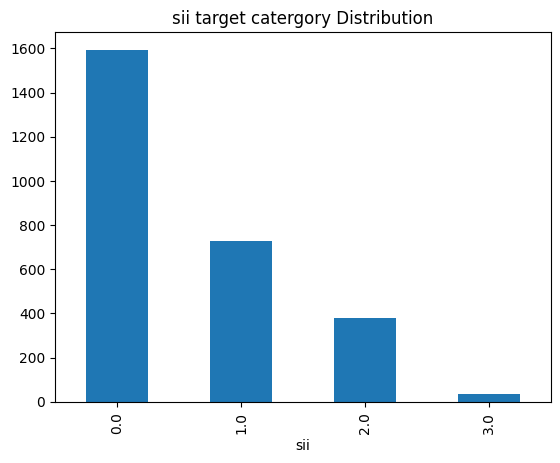

In [100]:
combinedTrainDF["sii"].value_counts().plot(kind="bar", title="sii target catergory Distribution");

In [101]:
combinedTrainDF.describe()

,Basic_Demos-Enroll_Season,CGAS-Season,Physical-Season,Fitness_Endurance-Season,FGC-Season,BIA-Season,PAQ_A-Season,PAQ_C-Season,SDS-Season,PreInt_EduHx-Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,X_count,Y_count,Z_count,enmo_count,anglez_count,non-wear_flag_count,light_count,battery_voltage_count,time_of_day_count,weekday_count,quarter_count,relative_date_PCIAT_count,X_mean,Y_mean,Z_mean,enmo_mean,anglez_mean,non-wear_flag_mean,light_mean,battery_voltage_mean,time_of_day_mean,weekday_mean,quarter_mean,relative_date_PCIAT_mean,X_std,Y_std,Z_std,enmo_std,anglez_std,non-wear_flag_std,light_std,battery_voltage_std,time_of_day_std,weekday_std,quarter_std,relative_date_PCIAT_std,X_min,Y_min,Z_min,enmo_min,anglez_min,non-wear_flag_min,light_min,battery_voltage_min,time_of_day_min,weekday_min,quarter_min,relative_date_PCIAT_min,X_25%,Y_25%,Z_25%,enmo_25%,anglez_25%,non-wear_flag_25%,light_25%,battery_voltage_25%,time_of_day_25%,weekday_25%,quarter_25%,relative_date_PCIAT_25%,X_50%,Y_50%,Z_50%,enmo_50%,anglez_50%,non-wear_flag_50%,light_50%,battery_voltage_50%,time_of_day_50%,weekday_50%,quarter_50%,relative_date_PCIAT_50%,X_75%,Y_75%,Z_75%,enmo_75%,anglez_75%,non-wear_flag_75%,light_75%,battery_voltage_75%,time_of_day_75%,weekday_75%,quarter_75%,relative_date_PCIAT_75%,X_max,Y_max,Z_max,enmo_max,anglez_max,non-wear_flag_max,light_max,battery_voltage_max,time_of_day_max,weekday_max,quarter_max,relative_date_PCIAT_max,sii,BMI-AGE,BMI-Classify,Waist-Height-Ratio,Waist-Height-Ratio-Classify,Internet-Hours-Age,BMI-Internet-Hours,FATPercent-Classify,ICW_TBW,FFMI_BFP,FMI_BFP,LST_TBW,BFP_BMR,BFP_DEE,BMR_Weight,DEE_Weight,SMM_Height,Muscle_to_Fat,Hydration_Status,BFP_BMI
count,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2.736000e+03,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2.736000e+03,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2.736000e+03,2736.000000,2736.0,2736.0,2736.000000,2.736000e+03,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2.736000e+03,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2736.000000,2.736000e+03,2736.000000,2736.000000,2736.000000,273

In [102]:
combinedTestDF.describe()

,Basic_Demos-Enroll_Season,CGAS-Season,Physical-Season,Fitness_Endurance-Season,FGC-Season,BIA-Season,PAQ_A-Season,PAQ_C-Season,SDS-Season,PreInt_EduHx-Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,X_count,Y_count,Z_count,enmo_count,anglez_count,non-wear_flag_count,light_count,battery_voltage_count,time_of_day_count,weekday_count,quarter_count,relative_date_PCIAT_count,X_mean,Y_mean,Z_mean,enmo_mean,anglez_mean,non-wear_flag_mean,light_mean,battery_voltage_mean,time_of_day_mean,weekday_mean,quarter_mean,relative_date_PCIAT_mean,X_std,Y_std,Z_std,enmo_std,anglez_std,non-wear_flag_std,light_std,battery_voltage_std,time_of_day_std,weekday_std,quarter_std,relative_date_PCIAT_std,X_min,Y_min,Z_min,enmo_min,anglez_min,non-wear_flag_min,light_min,battery_voltage_min,time_of_day_min,weekday_min,quarter_min,relative_date_PCIAT_min,X_25%,Y_25%,Z_25%,enmo_25%,anglez_25%,non-wear_flag_25%,light_25%,battery_voltage_25%,time_of_day_25%,weekday_25%,quarter_25%,relative_date_PCIAT_25%,X_50%,Y_50%,Z_50%,enmo_50%,anglez_50%,non-wear_flag_50%,light_50%,battery_voltage_50%,time_of_day_50%,weekday_50%,quarter_50%,relative_date_PCIAT_50%,X_75%,Y_75%,Z_75%,enmo_75%,anglez_75%,non-wear_flag_75%,light_75%,battery_voltage_75%,time_of_day_75%,weekday_75%,quarter_75%,relative_date_PCIAT_75%,X_max,Y_max,Z_max,enmo_max,anglez_max,non-wear_flag_max,light_max,battery_voltage_max,time_of_day_max,weekday_max,quarter_max,relative_date_PCIAT_max,BMI-AGE,BMI-Classify,Waist-Height-Ratio,Waist-Height-Ratio-Classify,Internet-Hours-Age,BMI-Internet-Hours,FATPercent-Classify,ICW_TBW,FFMI_BFP,FMI_BFP,LST_TBW,BFP_BMR,BFP_DEE,BMR_Weight,DEE_Weight,SMM_Height,Muscle_to_Fat,Hydration_Status,BFP_BMI
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01,20.000000,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01,20.000000,20.0,20.000000,20.000000,20.000000,20.000000,20.0,20.000000,20.0,20.0,20.000000,2.000000e+01,20.0,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.0,20.000000,20.000000,2.000000e+01,20.000000,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01,20.000000,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01,20.0,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01,20.0,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.

# Train/Validation Split
## K-fold Cross Vailation

In [103]:
xFeature = combinedTrainDF.drop("sii", axis=1)
yLabel = combinedTrainDF["sii"]

In [104]:
xFeature.shape  , yLabel.shape

((2736, 173), (2736,))

In [105]:
# Handling imbalance with SMOTE
if CFG.overSampling:
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(xFeature, yLabel)
    print(len(X_resampled))
    xFeature = X_resampled
    yLabel = y_resampled




6376


In [106]:
from sklearn.utils import compute_sample_weight, class_weight

In [107]:
xFeature.shape

(6376, 173)

In [108]:
xFeature

,Basic_Demos-Enroll_Season,CGAS-Season,Physical-Season,Fitness_Endurance-Season,FGC-Season,BIA-Season,PAQ_A-Season,PAQ_C-Season,SDS-Season,PreInt_EduHx-Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,X_count,Y_count,Z_count,enmo_count,anglez_count,non-wear_flag_count,light_count,battery_voltage_count,time_of_day_count,weekday_count,quarter_count,relative_date_PCIAT_count,X_mean,Y_mean,Z_mean,enmo_mean,anglez_mean,non-wear_flag_mean,light_mean,battery_voltage_mean,time_of_day_mean,weekday_mean,quarter_mean,relative_date_PCIAT_mean,X_std,Y_std,Z_std,enmo_std,anglez_std,non-wear_flag_std,light_std,battery_voltage_std,time_of_day_std,weekday_std,quarter_std,relative_date_PCIAT_std,X_min,Y_min,Z_min,enmo_min,anglez_min,non-wear_flag_min,light_min,battery_voltage_min,time_of_day_min,weekday_min,quarter_min,relative_date_PCIAT_min,X_25%,Y_25%,Z_25%,enmo_25%,anglez_25%,non-wear_flag_25%,light_25%,battery_voltage_25%,time_of_day_25%,weekday_25%,quarter_25%,relative_date_PCIAT_25%,X_50%,Y_50%,Z_50%,enmo_50%,anglez_50%,non-wear_flag_50%,light_50%,battery_voltage_50%,time_of_day_50%,weekday_50%,quarter_50%,relative_date_PCIAT_50%,X_75%,Y_75%,Z_75%,enmo_75%,anglez_75%,non-wear_flag_75%,light_75%,battery_voltage_75%,time_of_day_75%,weekday_75%,quarter_75%,relative_date_PCIAT_75%,X_max,Y_max,Z_max,enmo_max,anglez_max,non-wear_flag_max,light_max,battery_voltage_max,time_of_day_max,weekday_max,quarter_max,relative_date_PCIAT_max,BMI-AGE,BMI-Classify,Waist-Height-Ratio,Waist-Height-Ratio-Classify,Internet-Hours-Age,BMI-Internet-Hours,FATPercent-Classify,ICW_TBW,FFMI_BFP,FMI_BFP,LST_TBW,BFP_BMR,BFP_DEE,BMR_Weight,DEE_Weight,SMM_Height,Muscle_to_Fat,Hydration_Status,BFP_BMI
0,3,4,3,0,3,3,0,0,0,3,5,0,51.000000,16.877316,46.000000,50.800000,26.000000,68.000000,81.000000,114.000000,5.0,7.0,28.0,0.000000,0.000000,19.400000,2.000000,20.800000,2.000000,0.000000,0.0,7.000000,0.000000,6.000000,0.000000,6.000000,1.000000,2.000000,2.668550,16.879200,932.498000,1492.000000,8.255980,41.586200,13.817700,3.061430,9.213770,1.000000,24.434900,8.895360,38.917700,19.541300,32.690900,2.080000,2.550000,39.000000,55.000000,3.000000,383544.000000,383544.000000,383544.000000,383544.000000,383544.000000,383544.000000,383544.000000,383544.000000,383544.000000,383544.000000,383544.000000,383544.000000,-0.033658,0.008939,-0.141485,0.035104,-10.275450,0.051458,24.780988,3848.289673,4.340771e+13,4.001631,2.021691,33.756311,0.513798,0.476344,0.556131,0.091879,40.038872,0.208968,104.244904,160.041496,2.491238e+13,1.961505,0.0,6.741570,-1.771064,-2.412578,-1.016421,0.0,-89.748867,0.0,0.0,3098.166748,0.000000e+00,1.0,2.000000,21.000000,-0.488205,-0.287686,-0.608817,0.001030,-38.661846,0.000000,2.336633,3747.000000,2.183250e+13,2.0,2.000000,27.000000,-0.013372,0.006974,-0.174688,0.010069,-10.770489,0.000000,6.271717,3818.000000,4.367875e+13,4.0,2.000000,33.000000,0.224109,0.316078,0.244292,0.029585,14.188232,0.000000,15.806186,3970.000000,6.496438e+13,6.0,2.000000,40.000000,1.486703,2.112647,1.740934,3.806256,89.377281,1.0,2613.625000,4180.000000,8.639500e+13,7.0,3.000000,51.000000,84.386578,2,0.565217,3,15.000000,50.631947,0,0.747453,1.499679,0.332267,1.190475,8591.822097,13746.944840,18.356260,29.370079,0.424811,6.383063,0.643522,0.545865
1,2,0

In [109]:
# scale 
if CFG.normalize:
    scale = StandardScaler()
    scaledXFeature = scale.fit_transform(xFeature)
    xFeature = scaledXFeature
    scaledTestDF    = scale.fit_transform(combinedTestDF)
    combinedTestDF = scaledTestDF

In [110]:

xFeature

,Basic_Demos-Enroll_Season,CGAS-Season,Physical-Season,Fitness_Endurance-Season,FGC-Season,BIA-Season,PAQ_A-Season,PAQ_C-Season,SDS-Season,PreInt_EduHx-Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,X_count,Y_count,Z_count,enmo_count,anglez_count,non-wear_flag_count,light_count,battery_voltage_count,time_of_day_count,weekday_count,quarter_count,relative_date_PCIAT_count,X_mean,Y_mean,Z_mean,enmo_mean,anglez_mean,non-wear_flag_mean,light_mean,battery_voltage_mean,time_of_day_mean,weekday_mean,quarter_mean,relative_date_PCIAT_mean,X_std,Y_std,Z_std,enmo_std,anglez_std,non-wear_flag_std,light_std,battery_voltage_std,time_of_day_std,weekday_std,quarter_std,relative_date_PCIAT_std,X_min,Y_min,Z_min,enmo_min,anglez_min,non-wear_flag_min,light_min,battery_voltage_min,time_of_day_min,weekday_min,quarter_min,relative_date_PCIAT_min,X_25%,Y_25%,Z_25%,enmo_25%,anglez_25%,non-wear_flag_25%,light_25%,battery_voltage_25%,time_of_day_25%,weekday_25%,quarter_25%,relative_date_PCIAT_25%,X_50%,Y_50%,Z_50%,enmo_50%,anglez_50%,non-wear_flag_50%,light_50%,battery_voltage_50%,time_of_day_50%,weekday_50%,quarter_50%,relative_date_PCIAT_50%,X_75%,Y_75%,Z_75%,enmo_75%,anglez_75%,non-wear_flag_75%,light_75%,battery_voltage_75%,time_of_day_75%,weekday_75%,quarter_75%,relative_date_PCIAT_75%,X_max,Y_max,Z_max,enmo_max,anglez_max,non-wear_flag_max,light_max,battery_voltage_max,time_of_day_max,weekday_max,quarter_max,relative_date_PCIAT_max,BMI-AGE,BMI-Classify,Waist-Height-Ratio,Waist-Height-Ratio-Classify,Internet-Hours-Age,BMI-Internet-Hours,FATPercent-Classify,ICW_TBW,FFMI_BFP,FMI_BFP,LST_TBW,BFP_BMR,BFP_DEE,BMR_Weight,DEE_Weight,SMM_Height,Muscle_to_Fat,Hydration_Status,BFP_BMI
0,3,4,3,0,3,3,0,0,0,3,5,0,51.000000,16.877316,46.000000,50.800000,26.000000,68.000000,81.000000,114.000000,5.0,7.0,28.0,0.000000,0.000000,19.400000,2.000000,20.800000,2.000000,0.000000,0.0,7.000000,0.000000,6.000000,0.000000,6.000000,1.000000,2.000000,2.668550,16.879200,932.498000,1492.000000,8.255980,41.586200,13.817700,3.061430,9.213770,1.000000,24.434900,8.895360,38.917700,19.541300,32.690900,2.080000,2.550000,39.000000,55.000000,3.000000,383544.000000,383544.000000,383544.000000,383544.000000,383544.000000,383544.000000,383544.000000,383544.000000,383544.000000,383544.000000,383544.000000,383544.000000,-0.033658,0.008939,-0.141485,0.035104,-10.275450,0.051458,24.780988,3848.289673,4.340771e+13,4.001631,2.021691,33.756311,0.513798,0.476344,0.556131,0.091879,40.038872,0.208968,104.244904,160.041496,2.491238e+13,1.961505,0.0,6.741570,-1.771064,-2.412578,-1.016421,0.0,-89.748867,0.0,0.0,3098.166748,0.000000e+00,1.0,2.000000,21.000000,-0.488205,-0.287686,-0.608817,0.001030,-38.661846,0.000000,2.336633,3747.000000,2.183250e+13,2.0,2.000000,27.000000,-0.013372,0.006974,-0.174688,0.010069,-10.770489,0.000000,6.271717,3818.000000,4.367875e+13,4.0,2.000000,33.000000,0.224109,0.316078,0.244292,0.029585,14.188232,0.000000,15.806186,3970.000000,6.496438e+13,6.0,2.000000,40.000000,1.486703,2.112647,1.740934,3.806256,89.377281,1.0,2613.625000,4180.000000,8.639500e+13,7.0,3.000000,51.000000,84.386578,2,0.565217,3,15.000000,50.631947,0,0.747453,1.499679,0.332267,1.190475,8591.822097,13746.944840,18.356260,29.370079,0.424811,6.383063,0.643522,0.545865
1,2,0

In [111]:

combinedTestDF

,Basic_Demos-Enroll_Season,CGAS-Season,Physical-Season,Fitness_Endurance-Season,FGC-Season,BIA-Season,PAQ_A-Season,PAQ_C-Season,SDS-Season,PreInt_EduHx-Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,X_count,Y_count,Z_count,enmo_count,anglez_count,non-wear_flag_count,light_count,battery_voltage_count,time_of_day_count,weekday_count,quarter_count,relative_date_PCIAT_count,X_mean,Y_mean,Z_mean,enmo_mean,anglez_mean,non-wear_flag_mean,light_mean,battery_voltage_mean,time_of_day_mean,weekday_mean,quarter_mean,relative_date_PCIAT_mean,X_std,Y_std,Z_std,enmo_std,anglez_std,non-wear_flag_std,light_std,battery_voltage_std,time_of_day_std,weekday_std,quarter_std,relative_date_PCIAT_std,X_min,Y_min,Z_min,enmo_min,anglez_min,non-wear_flag_min,light_min,battery_voltage_min,time_of_day_min,weekday_min,quarter_min,relative_date_PCIAT_min,X_25%,Y_25%,Z_25%,enmo_25%,anglez_25%,non-wear_flag_25%,light_25%,battery_voltage_25%,time_of_day_25%,weekday_25%,quarter_25%,relative_date_PCIAT_25%,X_50%,Y_50%,Z_50%,enmo_50%,anglez_50%,non-wear_flag_50%,light_50%,battery_voltage_50%,time_of_day_50%,weekday_50%,quarter_50%,relative_date_PCIAT_50%,X_75%,Y_75%,Z_75%,enmo_75%,anglez_75%,non-wear_flag_75%,light_75%,battery_voltage_75%,time_of_day_75%,weekday_75%,quarter_75%,relative_date_PCIAT_75%,X_max,Y_max,Z_max,enmo_max,anglez_max,non-wear_flag_max,light_max,battery_voltage_max,time_of_day_max,weekday_max,quarter_max,relative_date_PCIAT_max,BMI-AGE,BMI-Classify,Waist-Height-Ratio,Waist-Height-Ratio-Classify,Internet-Hours-Age,BMI-Internet-Hours,FATPercent-Classify,ICW_TBW,FFMI_BFP,FMI_BFP,LST_TBW,BFP_BMR,BFP_DEE,BMR_Weight,DEE_Weight,SMM_Height,Muscle_to_Fat,Hydration_Status,BFP_BMI
0,3,4,3,0,3,3,0,0,0,3,5,0,51.0,16.877316,46.00,50.8,24.0,63.0,80.0,116.0,5.0,7.0,33.0,0.0,0.0,16.5,2.0,17.9,2.0,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,2.0,2.66855,16.87920,932.498,1492.00,8.25598,41.58620,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.91770,19.54130,32.69090,1.04,2.340,37.5,53.5,3.0,219863.0,219863.0,219863.0,219863.0,219863.0,219863.0,219863.0,219863.0,219863.0,219863.0,219863.0,219863.0,-0.160328,0.016434,-0.399811,0.029657,-33.105592,0.327854,29.534146,3945.884277,4.683713e+13,4.190015,3.0,66.318638,0.402605,0.403257,0.604593,0.065341,46.625402,0.234361,151.748207,133.988956,2.220053e+13,1.939156,0.0,10.439617,-1.392402,-2.214014,-1.033580,0.0,-89.297462,0.0,0.0,3461.083374,2.750000e+10,1.0,3.0,54.5,-0.368491,-0.177190,-0.829659,0.007527,-64.963956,0.0,1.446485,3887.833374,2.921500e+13,2.5,3.0,58.0,-0.193736,-0.001602,-0.626553,0.016734,-50.603268,0.5,3.902917,3941.0,4.839375e+13,4.5,3.0,64.5,-0.014879,0.210492,-0.044866,0.026044,-2.631300,0.5,10.570674,4049.093781,6.563188e+13,6.0,3.0,69.0,1.271108,1.806329,1.346631,3.478582,89.613846,0.5,2615.525024,4181.75,8.625250e+13,7.0,3.0,88.0,84.386578,2,0.521739,3,15.0,50.631947,0,0.747453,1.499679,0.332267,1.190475,8591.822097,13746.944840,18.356260,29.370079,0.424811,6.383063,0.643522,0.545865
1,2,0,3,0,3,4,0,3,3,2,9,0,63.0,14.035590,48.00,46.0,22.0,75.0,70.0,122.0,5.0,7.0,33.0,3.0,0.0,16.5,2.0,17.9,2.0,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,2.0,2.57949,14.03710,936.656,1498.65,6.01993,42.02910,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.44970,15.41070,27.05520,1.04,2.340,46.0,64.0,0.0,

In [112]:
if CFG.crossValidate:
    straKFold = StratifiedKFold(n_splits=CFG.nFold, random_state=42, shuffle=True)
else:
    X_train, X_test, y_train, y_test = train_test_split(xFeature, yLabel, test_size=CFG.test, 
                                                    random_state=42, stratify=yLabel)
    print(X_train.shape)
    print(X_test.shape)  
    print(y_train.shape)
    print(y_test.shape)
    # Compute sample_weight using compute_sample_weight
    sampleWeight = compute_sample_weight('balanced', y_train)
    classes_weights = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y_train)
    print(classes_weights)
    print(len(sampleWeight))

# inital Model

In [113]:
# XGBoost parameters
if device.type == "cuda":
    XGBparams = {
    'learning_rate': CFG.xgbLR, #0.05 #0.08, #0.01,#0.05,
    'max_depth': CFG.xgbDepth,  #5, #7, #6, low value avoid overfit
    'n_estimators':  CFG.xgbEstimate, # large number lead to overfit, small number lead to underfit
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,
    'reg_lambda': 5,
    'random_state': 42,
    'tree_method': 'hist',
    'device': 'cuda'
    }


else: # cpu base
     XGBparams = {
    'learning_rate': CFG.xgbLR, # 0.05 #0.08,#0.01, #0.05,
    'max_depth': CFG.xgbDepth, #7, #6, low value avoid overfit
    'n_estimators': CFG.xgbEstimate, #300, #200,  # large number lead to overfit, small number lead to underfit
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,
    'reg_lambda': 5,
    'random_state': 42,
    'tree_method': 'hist',
    'device': 'cpu'
    }




In [114]:
# xgb = XGBRFRegressor(**XGBparams ,  verbose=-1)
if CFG.crossValidate:
    xgb = XGBClassifier(**XGBparams ,  verbose=1, objective='multi:softmax', 
                    num_class=3)
    tabNet = TabNetClassifier(
             n_d=CFG.n_d, n_a=CFG.n_a, n_steps=CFG.n_steps,
                        optimizer_params=dict(lr=CFG.learningRate),
                        optimizer_fn=torch.optim.Adam,
                        scheduler_params={"step_size":10, 
                                         "gamma":0.9},
                        scheduler_fn=torch.optim.lr_scheduler.StepLR,
                        mask_type= CFG.mask_type, #'entmax' # "sparsemax"
        )
else:
    xgb = XGBClassifier(**XGBparams ,  verbose=1, objective='multi:softmax', 
                    num_class=3, sample_weight=sampleWeight)

    tabNet = TabNetClassifier(
             n_d=CFG.n_d, n_a=CFG.n_a, n_steps=CFG.n_steps,
                        optimizer_params=dict(lr=CFG.learningRate),
                        optimizer_fn=torch.optim.Adam,
                        scheduler_params={"step_size":10, 
                                         "gamma":0.9},
                        scheduler_fn=torch.optim.lr_scheduler.StepLR,
                        mask_type= CFG.mask_type, #'entmax' # "sparsemax"
        )

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [115]:
xgb.get_params()

{'objective': 'multi:softmax',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.8,
 'device': 'cpu',
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.05,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 7,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 200,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': 1,
 'reg_lambda': 5,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': 'hist',
 'validate_parameters': None,
 'verbosity': None,
 'verbose': 1,
 'num_class': 3}

In [116]:
lbg= LGBMClassifier()
lbg

LGBMClassifier()

In [117]:
def plotConfustionMatrix(actualVal, predictVal, modelName, trainORVal="Training"):
    CM = confusion_matrix(actualVal, predictVal)
    classifyReport =  classification_report(actualVal, predictVal)
    classifyReportDF =  classification_report(actualVal, predictVal, output_dict=True)
    print(f"\n\rClassification Report For {modelName} {trainORVal}:\n\r", classifyReport)
    cmd =ConfusionMatrixDisplay(CM)
    cmd.plot()
    plt.title(f"Confusion Matrix for {modelName} {trainORVal}")
    plt.show()
    return classifyReportDF

In [118]:
def plotKappa(trainKappa, valKappa, modelName):
    kFoldList = [item for item in range(1, len(trainKappa) + 1)]
    plt.figure(figsize=(6, 4))
    plt.plot(kFoldList, trainKappa, label='Training  Kappa')
    plt.plot(kFoldList, valKappa, label='Validation Kappa')
    plt.title(f'{modelName} Kappa (Training/Validation)')
    plt.xlabel('K-Fold')
    plt.ylabel('Kappa')
    plt.legend()
    plt.show()

In [119]:
modelHistory= {} # record all trained Model

|

# training Model
## Predict Train/Validation for Evalution Training performance

In [120]:
def trainValFunc(model , modelName):
    trainKappaHist =[]
    valKappaHist = []
    trainClassReportHist =[]
    valClassReportHist =[]
    if CFG.crossValidate:
        for i, (trainIdx, valIdx) in tqdm(enumerate(straKFold.split(xFeature, yLabel))):
            print(f"K-Fold: {i} ")
#             print(f"Train Idx : {trainIdx}")
#             print(f"Validate Idx: {valIdx}")
            # Set extract X_Train , X_test , y_train, y_test new split dataset 
            if CFG.normalize:
                X_train = xFeature[trainIdx, :] # filter/select train idx for X_Train
                X_test = xFeature[valIdx, :] # filter/select validation idx for X_Train
                y_train = yLabel[trainIdx]
                y_test  = yLabel[valIdx]
            else:
                X_train = xFeature.iloc[trainIdx, :] # filter/select train idx for X_Train
                X_test = xFeature.iloc[valIdx, :] # filter/select validation idx for X_Train
                y_train = yLabel.iloc[trainIdx]
                y_test  = yLabel.iloc[valIdx]
            # train model
            model.fit(X_train, y_train, verbose=True)
            # predict train dataset 
            yTrainPredict = model.predict(X_train)
#             print(yTrainPredict)
            yValPredict = model.predict(X_test)
#             print(yValPredict)
            trainClassifyReport = plotConfustionMatrix(y_train, yTrainPredict, 
                                                       modelName, trainORVal="Training")
            trainClassReportHist.append(trainClassifyReport)
            
            valClassifyReport = plotConfustionMatrix(y_test, yValPredict, 
                                                       modelName, trainORVal="Validation")
            valClassReportHist.append(valClassifyReport)
#             print(trainClassifyReport)
#             print(valClassifyReport)
            trainKappa = cohen_kappa_score(y_train, yTrainPredict)
            trainKappaHist.append(trainKappa)
            print(f"Training cohen Kappa score: {trainKappa}")
            valKappa = cohen_kappa_score(y_test, yValPredict)
            valKappaHist.append(valKappa)
            print(f"Val cohen Kappa score: {valKappa}")
            
        
            
        #store is Model History
        modelHistory[modelName] = {
            "k_Fold": CFG.nFold,
            "train_classify_report" : trainClassReportHist,
            "val_calssify_report": valClassReportHist,
            "train_kappa_score" : trainKappaHist,
            "val_kappa_score": valKappaHist
        }
            
            
#             
    else:
        # Train model
        model.fit(X_train, y_train)
        # Train dateset prediction 
        yTrainPredict = model.predict(X_train)
#         print(yTrainPredict)
        yValPredict = model.predict(X_test)
#         print(yValPredict)
        trainClassifyReport = plotConfustionMatrix(y_train, yTrainPredict, 
                                                       modelName, trainORVal="Training")
        trainClassReportHist.append(trainClassifyReport)
        valClassifyReport = plotConfustionMatrix(y_test, yValPredict, 
                                                       modelName, trainORVal="Validation")
        valClassReportHist.append(valClassifyReport)
#         print(trainClassifyReport)
#         print(valClassifyReport)
        trainKappa = cohen_kappa_score(y_train, yTrainPredict)
        trainKappaHist.append(trainKappa)
        print(f"Training cohen Kappa score: {trainKappa}")
        valKappa = cohen_kappa_score(y_test, yValPredict)
        print(f"Val cohen Kappa score: {valKappa}")
        valKappaHist.append(valKappa)
        
        #store is Model History
        modelHistory[modelName] = {
            "train_classify_report" : trainClassReportHist,
            "val_calssify_report": valClassReportHist,
            "train_kappa_score" : trainKappaHist,
            "val_kappa_score": valKappaHist
        }

0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:43:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


K-Fold: 0 

Classification Report For XGBoost Training:
               precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      1275
         1.0       0.99      0.96      0.97      1275
         2.0       0.99      0.97      0.98      1275
         3.0       1.00      1.00      1.00      1275

    accuracy                           0.98      5100
   macro avg       0.98      0.98      0.98      5100
weighted avg       0.98      0.98      0.98      5100



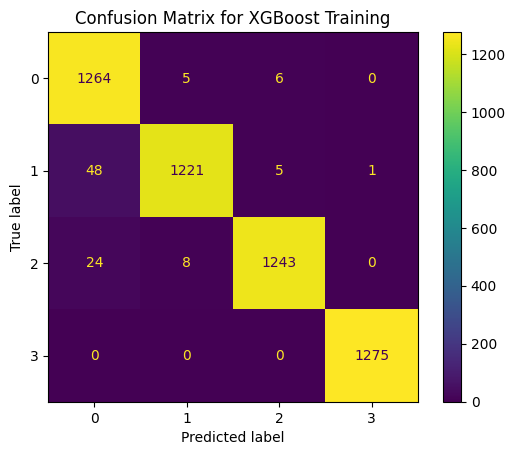


Classification Report For XGBoost Validation:
               precision    recall  f1-score   support

         0.0       0.72      0.86      0.78       319
         1.0       0.78      0.67      0.73       319
         2.0       0.88      0.82      0.85       319
         3.0       0.98      1.00      0.99       319

    accuracy                           0.84      1276
   macro avg       0.84      0.84      0.84      1276
weighted avg       0.84      0.84      0.84      1276



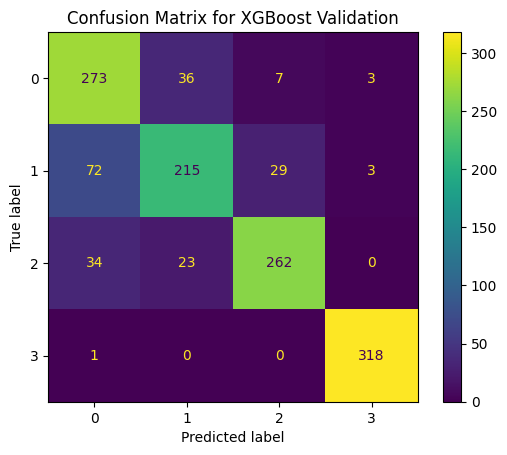

1it [00:13, 13.70s/it]

Training cohen Kappa score: 0.974640522875817
Val cohen Kappa score: 0.7826541274817137
K-Fold: 1 


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:43:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report For XGBoost Training:
               precision    recall  f1-score   support

         0.0       0.94      0.99      0.96      1275
         1.0       0.99      0.96      0.97      1275
         2.0       0.99      0.97      0.98      1275
         3.0       1.00      1.00      1.00      1276

    accuracy                           0.98      5101
   macro avg       0.98      0.98      0.98      5101
weighted avg       0.98      0.98      0.98      5101



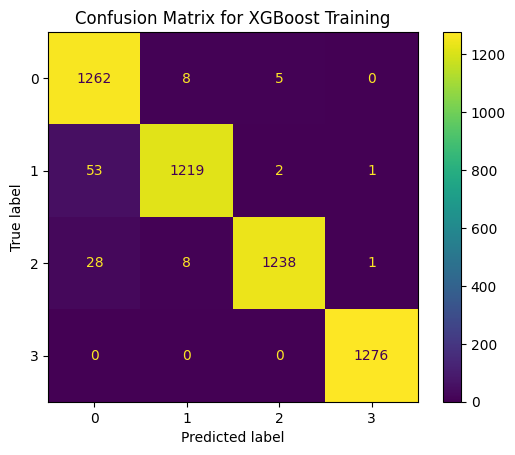


Classification Report For XGBoost Validation:
               precision    recall  f1-score   support

         0.0       0.72      0.84      0.77       319
         1.0       0.81      0.70      0.75       319
         2.0       0.88      0.84      0.86       319
         3.0       0.98      1.00      0.99       318

    accuracy                           0.84      1275
   macro avg       0.85      0.84      0.84      1275
weighted avg       0.85      0.84      0.84      1275



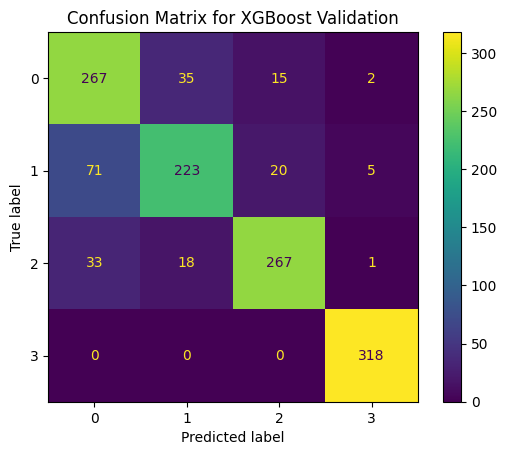

2it [00:26, 13.08s/it]

Training cohen Kappa score: 0.9722930105372504
Val cohen Kappa score: 0.7908509168931765
K-Fold: 2 


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:44:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report For XGBoost Training:
               precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      1275
         1.0       0.99      0.95      0.97      1276
         2.0       0.99      0.97      0.98      1275
         3.0       1.00      1.00      1.00      1275

    accuracy                           0.98      5101
   macro avg       0.98      0.98      0.98      5101
weighted avg       0.98      0.98      0.98      5101



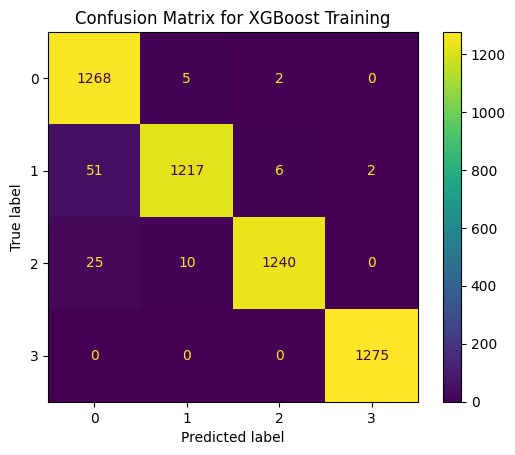


Classification Report For XGBoost Validation:
               precision    recall  f1-score   support

         0.0       0.71      0.82      0.76       319
         1.0       0.78      0.67      0.72       318
         2.0       0.87      0.85      0.86       319
         3.0       0.98      0.99      0.98       319

    accuracy                           0.83      1275
   macro avg       0.83      0.83      0.83      1275
weighted avg       0.83      0.83      0.83      1275



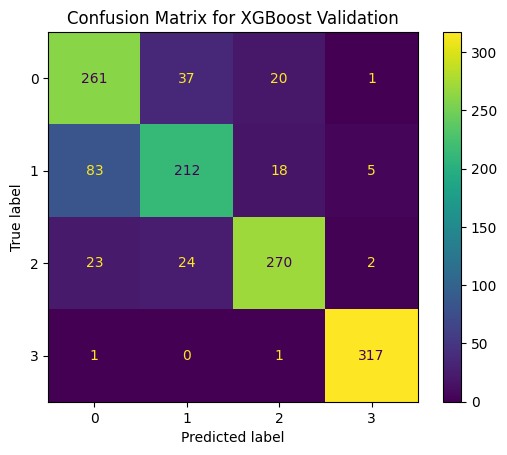

3it [00:39, 12.95s/it]

Training cohen Kappa score: 0.9736000062310424
Val cohen Kappa score: 0.7751549616010197
K-Fold: 3 


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:44:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report For XGBoost Training:
               precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      1276
         1.0       0.99      0.95      0.97      1275
         2.0       0.99      0.98      0.98      1275
         3.0       1.00      1.00      1.00      1275

    accuracy                           0.98      5101
   macro avg       0.98      0.98      0.98      5101
weighted avg       0.98      0.98      0.98      5101



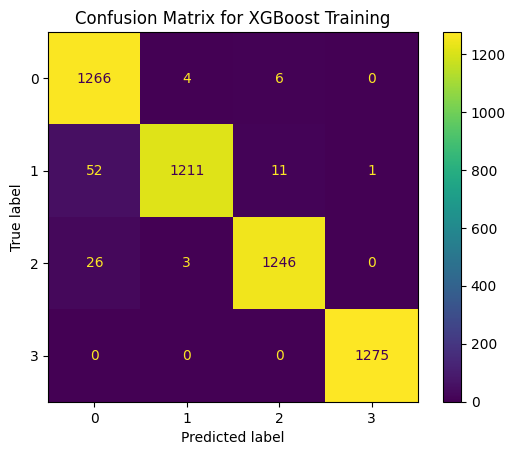


Classification Report For XGBoost Validation:
               precision    recall  f1-score   support

         0.0       0.71      0.83      0.77       318
         1.0       0.78      0.65      0.71       319
         2.0       0.85      0.84      0.84       319
         3.0       0.98      1.00      0.99       319

    accuracy                           0.83      1275
   macro avg       0.83      0.83      0.83      1275
weighted avg       0.83      0.83      0.83      1275



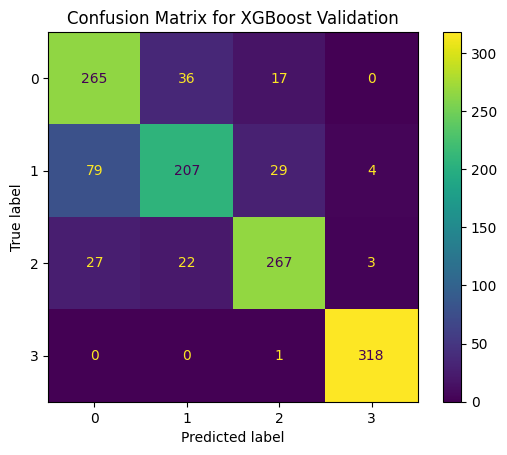

4it [00:52, 13.15s/it]

Training cohen Kappa score: 0.9730770795633858
Val cohen Kappa score: 0.7720359132629251
K-Fold: 4 


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:44:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report For XGBoost Training:
               precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      1275
         1.0       0.98      0.96      0.97      1275
         2.0       1.00      0.97      0.98      1276
         3.0       1.00      1.00      1.00      1275

    accuracy                           0.98      5101
   macro avg       0.98      0.98      0.98      5101
weighted avg       0.98      0.98      0.98      5101



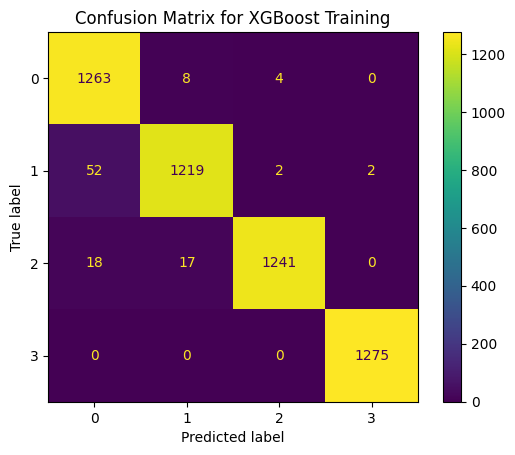


Classification Report For XGBoost Validation:
               precision    recall  f1-score   support

         0.0       0.77      0.82      0.79       319
         1.0       0.79      0.73      0.76       319
         2.0       0.87      0.87      0.87       318
         3.0       0.99      1.00      1.00       319

    accuracy                           0.85      1275
   macro avg       0.85      0.85      0.85      1275
weighted avg       0.85      0.85      0.85      1275



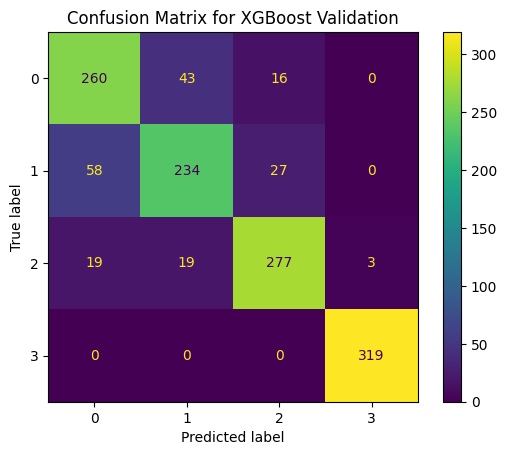

5it [01:05, 13.11s/it]

Training cohen Kappa score: 0.9730772133834898
Val cohen Kappa score: 0.8065361460605961
CPU times: user 2min 7s, sys: 2.04 s, total: 2min 9s
Wall time: 1min 5s


In [121]:
%%time
trainValFunc(xgb, "XGBoost")

In [122]:
modelHistory["XGBoost"]

{'k_Fold': 5,
 'train_classify_report': [{'0.0': {'precision': 0.9461077844311377,
    'recall': 0.9913725490196078,
    'f1-score': 0.9682114132516277,
    'support': 1275},
   '1.0': {'precision': 0.9894651539708266,
    'recall': 0.9576470588235294,
    'f1-score': 0.9732961339178955,
    'support': 1275},
   '2.0': {'precision': 0.9912280701754386,
    'recall': 0.9749019607843137,
    'f1-score': 0.9829972321075524,
    'support': 1275},
   '3.0': {'precision': 0.9992163009404389,
    'recall': 1.0,
    'f1-score': 0.999607996863975,
    'support': 1275},
   'accuracy': 0.9809803921568627,
   'macro avg': {'precision': 0.9815043273794605,
    'recall': 0.9809803921568627,
    'f1-score': 0.9810281940352626,
    'support': 5100},
   'weighted avg': {'precision': 0.9815043273794605,
    'recall': 0.9809803921568627,
    'f1-score': 0.9810281940352626,
    'support': 5100}},
  {'0.0': {'precision': 0.939687267311988,
    'recall': 0.9898039215686274,
    'f1-score': 0.964094728800611

In [123]:
modelHistory["XGBoost"]["val_kappa_score"]

[0.7826541274817137,
 0.7908509168931765,
 0.7751549616010197,
 0.7720359132629251,
 0.8065361460605961]

In [124]:
print("Average Training Kappa Score for XGBoost :", np.mean(modelHistory["XGBoost"]["train_kappa_score"]))
print("Average Val Kappa Score for XGBoost :", np.mean(modelHistory["XGBoost"]["val_kappa_score"]))

Average Training Kappa Score for XGBoost : 0.973337566518197
Average Val Kappa Score for XGBoost : 0.7854464130598863


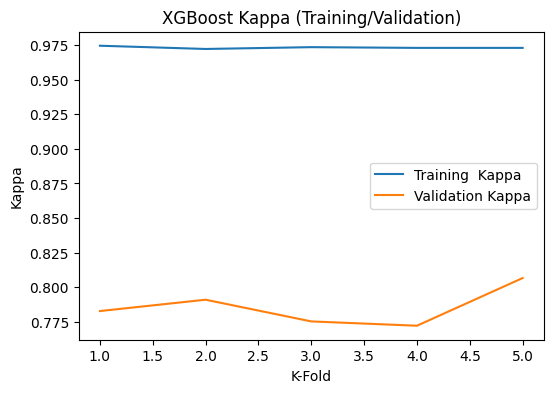

In [125]:
plotKappa(modelHistory["XGBoost"]["train_kappa_score"], 
          modelHistory["XGBoost"]["val_kappa_score"],
         "XGBoost")

## Ensemble Learning Algriothm, use multi-model for improve 

## Explainable AI 
#### Study and Understand How XGBoost trained model make decision

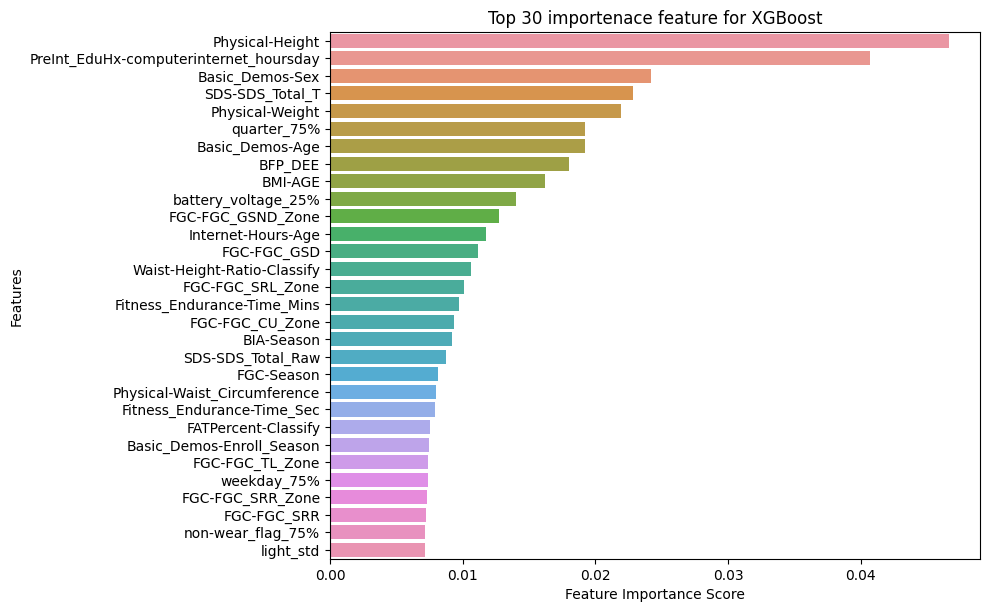

In [126]:
feature_impXGB = pd.Series(xgb.feature_importances_, index=tempCol2).sort_values(ascending=False)
xgbTop20 = feature_impXGB[:30]
plt.figure(figsize=(10,6))
sns.barplot(x=xgbTop20, y=xgbTop20.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.title("Top 30 importenace feature for XGBoost");
plt.show()
# xgboost.plot_importance(xgb);

<Figure size 1600x1600 with 0 Axes>

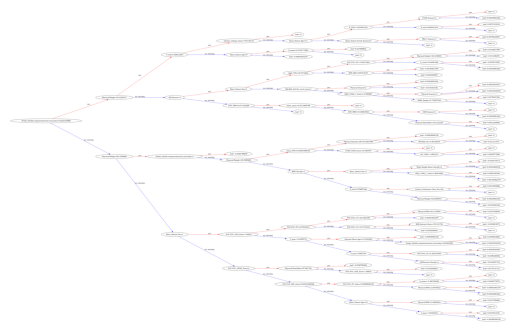

In [127]:
plt.figure(figsize=(16, 16))
xgboost.plot_tree(xgb,  num_trees=0, rankdir='LR')
plt.savefig("xgb_out.png",  dpi=600)
plt.show();

# Model Prediction for Submission

In [128]:
# 
def roundoff(arr, thresholds=[0.5, 1.5, 2.5]):
    return np.where(arr < thresholds[0], 0, 
                np.where(arr < thresholds[1], 1, 
                    np.where(arr < thresholds[2], 2, 3)))

In [129]:
submitPredict = xgb.predict(combinedTestDF)
submitPredict

array([2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 1, 1, 2, 2, 0, 0, 0, 2],
      dtype=int32)

In [130]:
roundedPredict = submitPredict # roundoff(submitPredict)
roundedPredict

array([2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 1, 1, 2, 2, 0, 0, 0, 2],
      dtype=int32)

In [131]:
submit["sii"] = roundedPredict

In [132]:
submit

,id,sii
0,00008ff9,2
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,0
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,2
9,0083e397,0


In [133]:
submit.to_csv('submission.csv', index=False)

In [134]:
sub = pd.read_csv("submission.csv")
sub

,id,sii
0,00008ff9,2
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,0
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,2
9,0083e397,0
